In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [6]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [7]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images
images = '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [45]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
print(train_img)

['/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/378170167_9b5119d918.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/378453580_21d688748e.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/3765374230_cb1bbee0cb.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/380515798_c2abbf46b0.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/380527679_574749123d.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/380537190_11d6c0a412.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/381275595_b429fd1639.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/382701159_f98c1988cd.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/380590140_25b9889772.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/382151094_c7376cf22b.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/383223174_7165a54c30.jpg

In [46]:
# Below file contains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
print(test_img)

['/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/3767841911_6678052eb6.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/384577800_fc325af410.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/387830531_e89c192b92.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/391579205_c8373b5411.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/396360611_941e5849a3.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/398662202_97e5819b79.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/400851260_5911898657.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/401079494_562454c4d6.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/405615014_03be7ef618.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/410453140_5401bf659a.jpg', '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/415793623_6c1225ae27.jpg

In [47]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [18]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 1s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print(encoding_train)
print("Time taken in seconds =", time()-start)

In [0]:
import pickle
# Save the bottleneck train features to disk
with open("/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
from tqdm import tqdm
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [0]:
# Save the bottleneck test features to disk
with open("/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [53]:
train_features = load(open("/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/encoded_train_images_inceptionV3_8k.p", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [54]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [57]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [59]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2531

In [60]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [65]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-26 06:47:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-26 06:47:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-26 06:47:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [68]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [69]:
# Load Glove vectors
glove_dir = '/content'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector



In [71]:
embedding_matrix.shape

(2531, 200)

In [72]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [73]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_json = model.to_json()
with open("approach2_model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [81]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Image Caption/Flickr/approach2/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 164s 82ms/step - loss: 3.1316 - acc: 0.3198
Epoch 1/1
2000/2000 [==============================] - 167s 83ms/step - loss: 3.0309 - acc: 0.3281
Epoch 1/1
2000/2000 [==============================] - 166s 83ms/step - loss: 2.9498 - acc: 0.3348
Epoch 1/1
2000/2000 [==============================] - 167s 84ms/step - loss: 2.8857 - acc: 0.3397
Epoch 1/1
2000/2000 [==============================] - 167s 83ms/step - loss: 2.8307 - acc: 0.3466
Epoch 1/1
2000/2000 [==============================] - 169s 84ms/step - loss: 2.7844 - acc: 0.3512
Epoch 1/1
2000/2000 [==============================] - 171s 86ms/step - loss: 2.7456 - acc: 0.3556
Epoch 1/1
2000/2000 [==============================] - 173s 87ms/step - loss: 2.7133 - acc: 0.3583
Epoch 1/1
2000/2000 [==============================] - 171s 85ms/step - loss: 2.6818 - acc: 0.3612
Epoch 1/1
2000/2000 [==============================] - 171s 85ms/step - loss: 2.6561 - acc: 0.3642


In [82]:
epochs = 5
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Image Caption/Flickr/approach2/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 171s 86ms/step - loss: 2.6337 - acc: 0.3666
Epoch 1/1
2000/2000 [==============================] - 171s 86ms/step - loss: 2.6159 - acc: 0.3697
Epoch 1/1
2000/2000 [==============================] - 172s 86ms/step - loss: 2.5949 - acc: 0.3711
Epoch 1/1
2000/2000 [==============================] - 172s 86ms/step - loss: 2.5796 - acc: 0.3739
Epoch 1/1
2000/2000 [==============================] - 169s 85ms/step - loss: 2.5636 - acc: 0.3751


In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [94]:
epochs = 5
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('/content/drive/My Drive/Image Caption/Flickr/approach2/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 91s 91ms/step - loss: 2.4852 - acc: 0.3874
Epoch 1/1
1000/1000 [==============================] - 91s 91ms/step - loss: 2.4734 - acc: 0.3891
Epoch 1/1
1000/1000 [==============================] - 90s 90ms/step - loss: 2.4592 - acc: 0.3907
Epoch 1/1
1000/1000 [==============================] - 90s 90ms/step - loss: 2.4483 - acc: 0.3923
Epoch 1/1
1000/1000 [==============================] - 90s 90ms/step - loss: 2.4396 - acc: 0.3933


In [0]:
model.save_weights('/content/drive/My Drive/Image Caption/Flickr/approach2/model_20.h5')

**TEST THE MODEL**

In [0]:
ixtoword = {1: 'startseq', 2: 'child', 3: 'in', 4: 'pink', 5: 'dress', 6: 'is', 7: 'climbing', 8: 'up', 9: 'set', 10: 'of', 11: 'stairs', 12: 'an', 13: 'way', 14: 'endseq', 15: 'girl', 16: 'going', 17: 'into', 18: 'wooden', 19: 'building', 20: 'little', 21: 'playhouse', 22: 'the', 23: 'to', 24: 'her', 25: 'black', 26: 'dog', 27: 'and', 28: 'spotted', 29: 'are', 30: 'fighting', 31: 'tricolored', 32: 'playing', 33: 'with', 34: 'each', 35: 'other', 36: 'on', 37: 'road', 38: 'white', 39: 'brown', 40: 'spots', 41: 'staring', 42: 'at', 43: 'street', 44: 'two', 45: 'dogs', 46: 'different', 47: 'breeds', 48: 'looking', 49: 'pavement', 50: 'moving', 51: 'toward', 52: 'covered', 53: 'paint', 54: 'sits', 55: 'front', 56: 'painted', 57: 'rainbow', 58: 'hands', 59: 'bowl', 60: 'sitting', 61: 'large', 62: 'small', 63: 'grass', 64: 'plays', 65: 'it', 66: 'there', 67: 'pigtails', 68: 'painting', 69: 'young', 70: 'outside', 71: 'man', 72: 'lays', 73: 'bench', 74: 'while', 75: 'his', 76: 'by', 77: 'him', 78: 'which', 79: 'also', 80: 'tied', 81: 'sleeping', 82: 'next', 83: 'shirtless', 84: 'lies', 85: 'park', 86: 'laying', 87: 'holding', 88: 'leash', 89: 'ground', 90: 'orange', 91: 'hat', 92: 'starring', 93: 'something', 94: 'wears', 95: 'glasses', 96: 'wearing', 97: 'beer', 98: 'can', 99: 'pierced', 100: 'ears', 101: 'rope', 102: 'net', 103: 'red', 104: 'climbs', 105: 'bridge', 106: 'onto', 107: 'ropes', 108: 'playground', 109: 'running', 110: 'grassy', 111: 'garden', 112: 'surrounded', 113: 'fence', 114: 'through', 115: 'boston', 116: 'terrier', 117: 'lush', 118: 'green', 119: 'runs', 120: 'near', 121: 'shakes', 122: 'its', 123: 'head', 124: 'shore', 125: 'ball', 126: 'edge', 127: 'beach', 128: 'feet', 129: 'stands', 130: 'shaking', 131: 'off', 132: 'water', 133: 'standing', 134: 'turned', 135: 'one', 136: 'side', 137: 'boy', 138: 'smiles', 139: 'wall', 140: 'city', 141: 'overalls', 142: 'working', 143: 'stone', 144: 'walking', 145: 'paved', 146: 'metal', 147: 'pole', 148: 'behind', 149: 'smiling', 150: 'shirt', 151: 'blue', 152: 'jeans', 153: 'rock', 154: 'leaps', 155: 'over', 156: 'log', 157: 'grey', 158: 'leaping', 159: 'fallen', 160: 'tree', 161: 'collar', 162: 'jumping', 163: 'jumped', 164: 'stump', 165: 'snow', 166: 'field', 167: 'surface', 168: 'pictures', 169: 'skier', 170: 'skis', 171: 'past', 172: 'another', 173: 'person', 174: 'framed', 175: 'looks', 176: 'trees', 177: 'for', 178: 'cliff', 179: 'group', 180: 'people', 181: 'seven', 182: 'climbers', 183: 'ascending', 184: 'face', 185: 'whilst', 186: 'several', 187: 'row', 188: 'watches', 189: 'holds', 190: 'line', 191: 'chases', 192: 'from', 193: 'sprinkler', 194: 'lawn', 195: 'hose', 196: 'away', 197: 'prepares', 198: 'catch', 199: 'thrown', 200: 'object', 201: 'nearby', 202: 'cars', 203: 'about', 204: 'yellow', 205: 'mouth', 206: 'toy', 207: 'ready', 208: 'flying', 209: 'air', 210: 'after', 211: 'get', 212: 'jumps', 213: 'towards', 214: 'trying', 215: 'midair', 216: 'couple', 217: 'infant', 218: 'being', 219: 'held', 220: 'male', 221: 'pond', 222: 'stroller', 223: 'sit', 224: 'baby', 225: 'their', 226: 'newborn', 227: 'under', 228: 'facing', 229: 'lake', 230: 'woman', 231: 'along', 232: 'body', 233: 'outdoors', 234: 'surf', 235: 'lab', 236: 'tags', 237: 'splashes', 238: 'this', 239: 'splashing', 240: 'drilling', 241: 'hole', 242: 'ice', 243: 'frozen', 244: 'men', 245: 'fishing', 246: 'play', 247: 'making', 248: 'turn', 249: 'soft', 250: 'sand', 251: 'together', 252: 'tan', 253: 'sandy', 254: 'uses', 255: 'picks', 256: 'climber', 257: 'jacket', 258: 'pants', 259: 'scaling', 260: 'waterfall', 261: 'carries', 262: 'as', 263: 'he', 264: 'walks', 265: 'carrying', 266: 'has', 267: 'item', 268: 'wet', 269: 'kayak', 270: 'life', 271: 'jackets', 272: 'rowing', 273: 'canoe', 274: 'waters', 275: 'ride', 276: 'courtyard', 277: 'catching', 278: 'lunges', 279: 'chocolate', 280: 'too', 281: 'driveway', 282: 'art', 283: 'structure', 284: 'glass', 285: 'reads', 286: 'newspaper', 287: 'sculpture', 288: 'office', 289: 'statue', 290: 'backpack', 291: 'buildings', 292: 'reading', 293: 'tent', 294: 'enter', 295: 'setting', 296: 'hut', 297: 'tarp', 298: 'snowy', 299: 'skyscraper', 300: 'very', 301: 'tall', 302: 'distance', 303: 'camera', 304: 'mountainside', 305: 'out', 306: 'view', 307: 'three', 308: 'overlooking', 309: 'valley', 310: 'hang', 311: 'top', 312: 'big', 313: 'hill', 314: 'overlook', 315: 'rest', 316: 'ledge', 317: 'above', 318: 'down', 319: 'many', 320: 'inflatable', 321: 'boats', 322: 'railing', 323: 'rafts', 324: 'below', 325: 'crowd', 326: 'jersey', 327: 'pose', 328: 'hand', 329: 'some', 330: 'posing', 331: 'picture', 332: 'asian', 333: 'blond', 334: 'background', 335: 'guy', 336: 'biting', 337: 'striped', 338: 'rail', 339: 'crowded', 340: 'takes', 341: 'jump', 342: 'skateboard', 343: 'performing', 344: 'trick', 345: 'leans', 346: 'skateboarder', 347: 'doing', 348: 'board', 349: 'platform', 350: 'skateboarders', 351: 'paddling', 352: 'river', 353: 'seen', 354: 'kayaking', 355: 'paddles', 356: 'boat', 357: 'paddle', 358: 'shallow', 359: 'girls', 360: 'ocean', 361: 'four', 362: 'children', 363: 'pajamas', 364: 'have', 365: 'pillow', 366: 'fight', 367: 'kids', 368: 'bed', 369: 'having', 370: 'workers', 371: 'beam', 372: 'taking', 373: 'break', 374: 'construction', 375: 'take', 376: 'seat', 377: 'train', 378: 'rides', 379: 'book', 380: 'rocky', 381: 'run', 382: 'across', 383: 'stones', 384: 'area', 385: 'descends', 386: 'end', 387: 'high', 388: 'diving', 389: 'pool', 390: 'kid', 391: 'swimming', 392: 'dive', 393: 'window', 394: 'tank', 395: 'door', 396: 'puts', 397: 'elevator', 398: 'putting', 399: 'light', 400: 'hiker', 401: 'mountains', 402: 'ski', 403: 'landscape', 404: 'snowcovered', 405: 'mountain', 406: 'beautiful', 407: 'pauses', 408: 'mountaintop', 409: 'attempting', 410: 'purple', 411: 'low', 412: 'cut', 413: 'yard', 414: 'frisbee', 415: 'shorts', 416: 'parking', 417: 'lot', 418: 'middle', 419: 'during', 420: 'heavy', 421: 'traffic', 422: 'mat', 423: 'between', 424: 'suv', 425: 'open', 426: 'busy', 427: 'terrain', 428: 'doberman', 429: 'chasing', 430: 'catches', 431: 'tennis', 432: 'multicolor', 433: 'watching', 434: 'balloons', 435: 'night', 436: 'hot', 437: 'lit', 438: 'lined', 439: 'nighttime', 440: 'helmet', 441: 'bike', 442: 'miniature', 443: 'dirt', 444: 'bicycle', 445: 'race', 446: 'quickly', 447: 'bmx', 448: 'dark', 449: 'throwing', 450: 'bubbles', 451: 'clean', 452: 'foam', 453: 'ramp', 454: 'getting', 455: 'sticks', 456: 'tongue', 457: 'boys', 458: 'make', 459: 'faces', 460: 'sticking', 461: 'look', 462: 'silly', 463: 'blonde', 464: 'horse', 465: 'sweatshirt', 466: 'fire', 467: 'barrel', 468: 'stand', 469: 'lead', 470: 'horses', 471: 'sheep', 472: 'boxer', 473: 'pushing', 474: 'skinny', 475: 'smaller', 476: 'int', 477: 'them', 478: 'various', 479: 'artificial', 480: 'safety', 481: 'harness', 482: 'indoor', 483: 'rocks', 484: 'ring', 485: 'teenage', 486: 'slide', 487: 'seating', 488: 'skiiers', 489: 'forest', 490: 'skiing', 491: 'wooded', 492: 'crosscountry', 493: 'skiers', 494: 'woodland', 495: 'sliding', 496: 'trail', 497: 'woods', 498: 'lone', 499: 'hikers', 500: 'pathway', 501: 'path', 502: 'happily', 503: 'dressed', 504: 'pony', 505: 'atop', 506: 'pull', 507: 'cart', 508: 'golden', 509: 'driven', 510: 'coat', 511: 'pulling', 512: 'carriage', 513: 'sled', 514: 'sheer', 515: 'using', 516: 'flat', 517: 'steep', 518: 'incline', 519: 'vest', 520: 'inside', 521: 'cave', 522: 'shows', 523: 'sunlight', 524: 'lay', 525: 'dry', 526: 'resting', 527: 'camp', 528: 'gear', 529: 'chalk', 530: 'stream', 531: 'drawing', 532: 'elaborate', 533: 'sidewalk', 534: 'deep', 535: 'pile', 536: 'fountain', 537: 'fountains', 538: 'sprayed', 539: 'tunnel', 540: 'course', 541: 'obstacle', 542: 'around', 543: 'swimsuit', 544: 'arms', 545: 'outstretched', 546: 'handrail', 547: 'bathing', 548: 'suit', 549: 'drinking', 550: 'spray', 551: 'soaked', 552: 'jet', 553: 'shower', 554: 'gets', 555: 'underwater', 556: 'redheaded', 557: 'swims', 558: 'alone', 559: 'jagged', 560: 'snowmobile', 561: 'flies', 562: 'rider', 563: 'or', 564: 'machine', 565: 'pine', 566: 'rural', 567: 'riding', 568: 'helmets', 569: 'goggles', 570: 'helmeted', 571: 'drive', 572: 'heads', 573: 'atv', 574: 'wheel', 575: 'wheeler', 576: 'empty', 577: 'all', 578: 'vehicle', 579: 'airborne', 580: 'soccer', 581: 'arm', 582: 'tshirt', 583: 'artist', 584: 'paints', 585: 'clouds', 586: 'colors', 587: 'paper', 588: 'cyclist', 589: 'sharp', 590: 'curve', 591: 'cows', 592: 'biker', 593: 'old', 594: 'video', 595: 'cheeks', 596: 'lips', 597: 'gun', 598: 'border', 599: 'collie', 600: 'audience', 601: 'watch', 602: 'onlookers', 603: 'smooth', 604: 'toddler', 605: 'shoes', 606: 'attached', 607: 'that', 608: 'sprays', 609: 'frog', 610: 'public', 611: 'wood', 612: 'animal', 613: 'bird', 614: 'eating', 615: 'seeds', 616: 'someone', 617: 'eats', 618: 'finger', 619: 'fast', 620: 'wades', 621: 'laughs', 622: 'colorful', 623: 'outdoor', 624: 'handstand', 625: 'does', 626: 'sheets', 627: 'upside', 628: 'snowboard', 629: 'surfboard', 630: 'bikes', 631: 'traveling', 632: 'worn', 633: 'motorcycles', 634: 'motorbikes', 635: 'follow', 636: 'offroad', 637: 'half', 638: 'naked', 639: 'chair', 640: 'older', 641: 'back', 642: 'relaxes', 643: 'patio', 644: 'where', 645: 'bicycles', 646: 'cap', 647: 'deck', 648: 'close', 649: 'parked', 650: 'relaxing', 651: 'folding', 652: 'topless', 653: 'navy', 654: 'floating', 655: 'both', 656: 'retrieve', 657: 'mouths', 658: 'tug', 659: 'chew', 660: 'haired', 661: 'drink', 662: 'hair', 663: 'party', 664: 'streets', 665: 'they', 666: 'women', 667: 'parade', 668: 'creating', 669: 'splash', 670: 'sandals', 671: 'short', 672: 'sleeved', 673: 'backpacks', 674: 'placed', 675: 'cardboard', 676: 'bus', 677: 'station', 678: 'folded', 679: 'room', 680: 'bedroom', 681: 'plants', 682: 'crossing', 683: 'greenery', 684: 'tropical', 685: 'caution', 686: 'sign', 687: 'beside', 688: 'family', 689: 'gathered', 690: 'van', 691: 'bright', 692: 'truck', 693: 'others', 694: 'helping', 695: 'step', 696: 'pulled', 697: 'passengers', 698: 'brightly', 699: 'poses', 700: 'costume', 701: 'hugs', 702: 'who', 703: 'embracing', 704: 'event', 705: 'hugging', 706: 'stretch', 707: 'bicyclist', 708: 'cross', 709: 'biking', 710: 'lady', 711: 'sky', 712: 'car', 713: 'wait', 714: 'jogging', 715: 'headset', 716: 'jogs', 717: 'headphones', 718: 'plant', 719: 'store', 720: 'corner', 721: 'bicyclists', 722: 'intersection', 723: 'waiting', 724: 'bikers', 725: 'stop', 726: 'town', 727: 'without', 728: 'wagon', 729: 'leading', 730: 'hits', 731: 'tee', 732: 'practices', 733: 'hitting', 734: 'baseball', 735: 'adult', 736: 'put', 737: 'batting', 738: 'cage', 739: 'spins', 740: 'waves', 741: 'sun', 742: 'she', 743: 'marching', 744: 'band', 745: 'teenager', 746: 'game', 747: 'sneakers', 748: 'leap', 749: 'elderly', 750: 'straw', 751: 'gray', 752: 'sweater', 753: 'walk', 754: 'hallway', 755: 'colored', 756: 'flip', 757: 'flops', 758: 'hood', 759: 'legs', 760: 'boulder', 761: 'clear', 762: 'hooded', 763: 'bending', 764: 'blanket', 765: 'stuffed', 766: 'animals', 767: 'giving', 768: 'toys', 769: 'war', 770: 'floor', 771: 'nose', 772: 'silver', 773: 'closeup', 774: 'games', 775: 'bar', 776: 'neon', 777: 'hanging', 778: 'bank', 779: 'computer', 780: 'machines', 781: 'rough', 782: 'parents', 783: 'carts', 784: 'pushed', 785: 'shaped', 786: 'strollers', 787: 'toddlers', 788: 'alike', 789: 'plastic', 790: 'team', 791: 'wear', 792: 'uniforms', 793: 'same', 794: 'hats', 795: 'sporting', 796: 'florida', 797: 'dolphin', 798: 'caps', 799: 'flowers', 800: 'shaggy', 801: 'stick', 802: 'long', 803: 'alongside', 804: 'advertisement', 805: 'backlit', 806: 'subway', 807: 'umbrella', 808: 'unicycle', 809: 'scooter', 810: 'reaches', 811: 'dock', 812: 'post', 813: 'pier', 814: 'concrete', 815: 'landing', 816: 'table', 817: 'snack', 818: 'picnic', 819: 'luggage', 820: 'eat', 821: 'flowery', 822: 'floral', 823: 'purse', 824: 'stretched', 825: 'tussle', 826: 'suspended', 827: 'igloo', 828: 'type', 829: 'dangling', 830: 'strange', 831: 'eyes', 832: 'shining', 833: 'closed', 834: 'photo', 835: 'outfit', 836: 'photograph', 837: 'just', 838: 'church', 839: 'climb', 840: 'cleaning', 841: 'windows', 842: 'swing', 843: 'swings', 844: 'heels', 845: 'brick', 846: 'weeds', 847: 'against', 848: 'wrestle', 849: 'plain', 850: 'clothes', 851: 'cushion', 852: 'asleep', 853: 'sofa', 854: 'pacifier', 855: 'sucking', 856: 'teddy', 857: 'bear', 858: 'sells', 859: 'soda', 860: 'cans', 861: 'vendor', 862: 'selling', 863: 'drinks', 864: 'stall', 865: 'males', 866: 'print', 867: 'gold', 868: 'stove', 869: 'pipe', 870: 'makeup', 871: 'benches', 872: 'tile', 873: 'sunglasses', 874: 'overpass', 875: 'mask', 876: 'wetsuit', 877: 'bald', 878: 'containing', 879: 'flips', 880: 'tumbling', 881: 'ear', 882: 'bite', 883: 'number', 884: 'six', 885: 'chased', 886: 'kneeling', 887: 'approaching', 888: 'thin', 889: 'carpet', 890: 'rug', 891: 'lying', 892: 'furry', 893: 'suits', 894: 'friends', 895: 'smile', 896: 'ladies', 897: 'bikinis', 898: 'sat', 899: 'reflection', 900: 'marble', 901: 'dances', 902: 'hips', 903: 'skirt', 904: 'crouches', 905: 'writing', 906: 'blurry', 907: 'descending', 908: 'kicking', 909: 'stepping', 910: 'police', 911: 'motorcycle', 912: 'motorized', 913: 'muddy', 914: 'motorbike', 915: 'uphill', 916: 'motocross', 917: 'circuit', 918: 'racer', 919: 'jumpsuit', 920: 'display', 921: 'underwear', 922: 'pairs', 923: 'wire', 924: 'awning', 925: 'stopped', 926: 'creek', 927: 'leaning', 928: 'motion', 929: 'says', 930: 'logo', 931: 'sunset', 932: 'float', 933: 'drives', 934: 'waits', 935: 'driving', 936: 'handbag', 937: 'leashed', 938: 'lap', 939: 'tries', 940: 'playpen', 941: 'female', 942: 'mountainous', 943: 'summit', 944: 'football', 945: 'foot', 946: 'first', 947: 'seated', 948: 'candle', 949: 'candles', 950: 'birthday', 951: 'place', 952: 'cake', 953: 'trotting', 954: 'few', 955: 'adults', 956: 'splashed', 957: 'sunny', 958: 'day', 959: 'lots', 960: 'shown', 961: 'cloudy', 962: 'khaki', 963: 'structures', 964: 'passes', 965: 'wakeboarder', 966: 'sideways', 967: 'waterskier', 968: 'performs', 969: 'tricks', 970: 'waterskiing', 971: 'knee', 972: 'begins', 973: 'fall', 974: 'wakeboard', 975: 'wakeboarding', 976: 'younger', 977: 'watercraft', 978: 'fish', 979: 'stare', 980: 'tiled', 981: 'pitch', 982: 'uniform', 983: 'player', 984: 'africanamerican', 985: 'darkskinned', 986: 'halter', 987: 'backyard', 988: 'stuck', 989: 'husky', 990: 'straps', 991: 'turning', 992: 'harnesses', 993: 'wide', 994: 'barks', 995: 'shoulder', 996: 'fluffy', 997: 'grab', 998: 'tables', 999: 'talks', 1000: 'showing', 1001: 'squatting', 1002: 'talking', 1003: 'phone', 1004: 'cellphone', 1005: 'flower', 1006: 'attire', 1007: 'electronic', 1008: 'device', 1009: 'backpacker', 1010: 'american', 1011: 'flag', 1012: 'hiking', 1013: 'hikes', 1014: 'underneath', 1015: 'unseen', 1016: 'stool', 1017: 'chairs', 1018: 'including', 1019: 'gives', 1020: 'evil', 1021: 'eye', 1022: 'trunks', 1023: 'reflective', 1024: 'swim', 1025: 'watery', 1026: 'block', 1027: 'dirty', 1028: 'bottle', 1029: 'leotard', 1030: 'checkered', 1031: 'tight', 1032: 'bars', 1033: 'hangs', 1034: 'monkey', 1035: 'jungle', 1036: 'gym', 1037: 'ladder', 1038: 'warm', 1039: 'swinging', 1040: 'gown', 1041: 'wings', 1042: 'slides', 1043: 'floaties', 1044: 'hit', 1045: 'jean', 1046: 'railroad', 1047: 'tracks', 1048: 'barefoot', 1049: 'bearded', 1050: 'turquoise', 1051: 'peace', 1052: 'stops', 1053: 'feather', 1054: 'headdress', 1055: 'shaved', 1056: 'shopping', 1057: 'earrings', 1058: 'bound', 1059: 'filled', 1060: 'wave', 1061: 'prepare', 1062: 'participating', 1063: 'sports', 1064: 'wakeboards', 1065: 'attempt', 1066: 'give', 1067: 'five', 1068: 'tire', 1069: 'racers', 1070: 'racing', 1071: 'laughing', 1072: 'bucket', 1073: 'beneath', 1074: 'boogie', 1075: 'trampoline', 1076: 'puppies', 1077: 'chase', 1078: 'heavily', 1079: 'cold', 1080: 'but', 1081: 'sets', 1082: 'hello', 1083: 'kitty', 1084: 'balloon', 1085: 'figure', 1086: 'right', 1087: 'slightly', 1088: 'floats', 1089: 'bikini', 1090: 'huge', 1091: 'scene', 1092: 'skimpy', 1093: 'foreground', 1094: 'skating', 1095: 'instructor', 1096: 'helps', 1097: 'skate', 1098: 'hold', 1099: 'go', 1100: 'rink', 1101: 'museum', 1102: 'retriever', 1103: 'kissing', 1104: 'cheek', 1105: 'tie', 1106: 'kiss', 1107: 'happy', 1108: 'shirts', 1109: 'vests', 1110: 'formal', 1111: 'balcony', 1112: 'amusement', 1113: 'carnival', 1114: 'brownhaired', 1115: 'shines', 1116: 'swords', 1117: 'sparring', 1118: 'bat', 1119: 'cup', 1120: 'rubber', 1121: 'referee', 1122: 'funny', 1123: 'bushes', 1124: 'matching', 1125: 'polo', 1126: 'lane', 1127: 'denim', 1128: 'gravel', 1129: 'land', 1130: 'puppy', 1131: 'beige', 1132: 'left', 1133: 'frame', 1134: 'help', 1135: 'push', 1136: 'among', 1137: 'cement', 1138: 'shop', 1139: 'retrieves', 1140: 'golf', 1141: 'hind', 1142: 'photos', 1143: 'new', 1144: 'taken', 1145: 'balls', 1146: 'no', 1147: 'fetch', 1148: 'spectators', 1149: 'pitbull', 1150: 'labrador', 1151: 'firefighter', 1152: 'fireman', 1153: 'spraying', 1154: 'jack', 1155: 'was', 1156: 'marker', 1157: 'house', 1158: 'mirror', 1159: 'hoodie', 1160: 'own', 1161: 'lines', 1162: 'softball', 1163: 'winding', 1164: 'throw', 1165: 'playfully', 1166: 'tosses', 1167: 'tossing', 1168: 'throws', 1169: 'marked', 1170: 'track', 1171: 'circle', 1172: 'camping', 1173: 'equipment', 1174: 'bags', 1175: 'bottom', 1176: 'base', 1177: 'surfing', 1178: 'made', 1179: 'dune', 1180: 'snowboarding', 1181: 'leaf', 1182: 'saddle', 1183: 'poodle', 1184: 'tub', 1185: 'full', 1186: 'container', 1187: 'bath', 1188: 'bin', 1189: 'cloth', 1190: 'wading', 1191: 'towel', 1192: 'overhang', 1193: 'formation', 1194: 'walkway', 1195: 'industrial', 1196: 'enjoying', 1197: 'wine', 1198: 'screen', 1199: 'laptop', 1200: 'earphones', 1201: 'snowboarder', 1202: 'cover', 1203: 'sheet', 1204: 'females', 1205: 'clothing', 1206: 'case', 1207: 'outfits', 1208: 'dresses', 1209: 'fishes', 1210: 'tops', 1211: 'these', 1212: 'you', 1213: 'hiviz', 1214: 'mustache', 1215: 'plaid', 1216: 'overlooks', 1217: 'bag', 1218: 'speaks', 1219: 'pot', 1220: 'coffee', 1221: 'restaurant', 1222: 'excited', 1223: 'be', 1224: 'only', 1225: 'retrieving', 1226: 'pack', 1227: 'father', 1228: 'lifting', 1229: 'peak', 1230: 'formations', 1231: 'star', 1232: 'like', 1233: 'cowboy', 1234: 'chain', 1235: 'neck', 1236: 'roller', 1237: 'coaster', 1238: 'airport', 1239: 'overhead', 1240: 'shot', 1241: 'carefully', 1242: 'poles', 1243: 'slope', 1244: 'innertube', 1245: 'saying', 1246: 'tube', 1247: 'shades', 1248: 'boots', 1249: 'brunette', 1250: 'combat', 1251: 'curb', 1252: 'bungee', 1253: 'cords', 1254: 'lift', 1255: 'strapped', 1256: 'rolling', 1257: 'trots', 1258: 'competing', 1259: 'agility', 1260: 'lifts', 1261: 'paw', 1262: 'palm', 1263: 'crash', 1264: 'test', 1265: 'robot', 1266: 'touch', 1267: 'gentleman', 1268: 'lean', 1269: 'second', 1270: 'droplets', 1271: 'themselves', 1272: 'waist', 1273: 'pirate', 1274: 'patch', 1275: 'bandanna', 1276: 'makes', 1277: 'fist', 1278: 'headscarf', 1279: 'catcher', 1280: 'teal', 1281: 'points', 1282: 'league', 1283: 'pointing', 1284: 'sides', 1285: 'teams', 1286: 'players', 1287: 'scenic', 1288: 'cobblestone', 1289: 'volleyball', 1290: 'athletic', 1291: 'stares', 1292: 'checking', 1293: 'preparing', 1294: 'forward', 1295: 'tracksuit', 1296: 'necklace', 1297: 'juice', 1298: 'trunk', 1299: 'pop', 1300: 'weather', 1301: 'guys', 1302: 'touches', 1303: 'mans', 1304: 'brother', 1305: 'reaching', 1306: 'gloves', 1307: 'food', 1308: 'speaking', 1309: 'box', 1310: 'hurdle', 1311: 'clears', 1312: 'obstacles', 1313: 'pulls', 1314: 'cigarette', 1315: 'lighting', 1316: 'fisherman', 1317: 'rod', 1318: 'mohawk', 1319: 'style', 1320: 'shade', 1321: 'ribbon', 1322: 'ninja', 1323: 'karate', 1324: 'martial', 1325: 'arts', 1326: 'practicing', 1327: 'enjoys', 1328: 'moment', 1329: 'german', 1330: 'piece', 1331: 'handles', 1332: 'touching', 1333: 'graffiti', 1334: 'skateboarding', 1335: 'skater', 1336: 'amidst', 1337: 'cloud', 1338: 'recently', 1339: 'hamburgers', 1340: 'kitchen', 1341: 'meal', 1342: 'jar', 1343: 'spread', 1344: 'tattooed', 1345: 'tattoos', 1346: 'backs', 1347: 'bathroom', 1348: 'facial', 1349: 'mother', 1350: 'feeding', 1351: 'son', 1352: 'watched', 1353: 'muscular', 1354: 'raising', 1355: 'almost', 1356: 'partially', 1357: 'treads', 1358: 'fields', 1359: 'shoulders', 1360: 'beard', 1361: 'hilly', 1362: 'disc', 1363: 'try', 1364: 'attempts', 1365: 'distant', 1366: 'scales', 1367: 'fun', 1368: 'bouncy', 1369: 'nap', 1370: 'multicolored', 1371: 'bent', 1372: 'branch', 1373: 'limb', 1374: 'chewing', 1375: 'gnawing', 1376: 'uncut', 1377: 'leafy', 1378: 'teeth', 1379: 'bleachers', 1380: 'really', 1381: 'third', 1382: 'teen', 1383: 'school', 1384: 'gate', 1385: 'crashing', 1386: 'rapids', 1387: 'cyclists', 1388: 'bottles', 1389: 'bread', 1390: 'branches', 1391: 'button', 1392: 'halloween', 1393: 'summer', 1394: 'tricycles', 1395: 'threewheeled', 1396: 'vehicles', 1397: 'growling', 1398: 'bites', 1399: 'steps', 1400: 'nearly', 1401: 'bouncing', 1402: 'enclosed', 1403: 'balancing', 1404: 'leg', 1405: 'see', 1406: 'gestures', 1407: 'gesture', 1408: 'dragging', 1409: 'though', 1410: 'emerges', 1411: 'kayaker', 1412: 'goes', 1413: 'maneuvers', 1414: 'rain', 1415: 'whitewater', 1416: 'kayaks', 1417: 'jeep', 1418: 'ditch', 1419: 'free', 1420: 'padded', 1421: 'training', 1422: 'attack', 1423: 'pale', 1424: 'downhill', 1425: 'cutting', 1426: 'bowls', 1427: 'court', 1428: 'visible', 1429: 'counter', 1430: 'mall', 1431: 'murky', 1432: 'rafting', 1433: 'flannel', 1434: 'tires', 1435: 'mickey', 1436: 'mouse', 1437: 'kilt', 1438: 'socks', 1439: 'leaves', 1440: 'longhaired', 1441: 'bounds', 1442: 'skateboards', 1443: 'do', 1444: 'homemade', 1445: 'apartment', 1446: 'mud', 1447: 'more', 1448: 'crosswalk', 1449: 'not', 1450: 'so', 1451: 'narrow', 1452: 'hills', 1453: 'autumn', 1454: 'bare', 1455: 'scuba', 1456: 'diver', 1457: 'hall', 1458: 'hardwood', 1459: 'coats', 1460: 'purses', 1461: 'ahead', 1462: 'parent', 1463: 'bottoms', 1464: 'choppy', 1465: 'petting', 1466: 'goats', 1467: 'lambs', 1468: 'arena', 1469: 'farm', 1470: 'fenced', 1471: 'pen', 1472: 'enclosure', 1473: 'goat', 1474: 'flowing', 1475: 'curly', 1476: 'upsidedown', 1477: 'flipping', 1478: 'gather', 1479: 'wrestling', 1480: 'gazes', 1481: 'horizon', 1482: 'kite', 1483: 'countryside', 1484: 'fly', 1485: 'current', 1486: 'wheelie', 1487: 'homeless', 1488: 'couch', 1489: 'litter', 1490: 'lower', 1491: 'moustache', 1492: 'scarf', 1493: 'beads', 1494: 'mom', 1495: 'slip', 1496: 'offcamera', 1497: 'bends', 1498: 'barren', 1499: 'skull', 1500: 'handlebars', 1501: 'maneuver', 1502: 'dust', 1503: 'storm', 1504: 'blowing', 1505: 'wind', 1506: 'urban', 1507: 'tools', 1508: 'digging', 1509: 'brush', 1510: 'kneels', 1511: 'thick', 1512: 'lands', 1513: 'string', 1514: 'handle', 1515: 'rests', 1516: 'canoeing', 1517: 'cooking', 1518: 'campsite', 1519: 'dinner', 1520: 'pouring', 1521: 'hay', 1522: 'buried', 1523: 'pumpkin', 1524: 'heart', 1525: 'bracelet', 1526: 'jewelry', 1527: 'fur', 1528: 'begging', 1529: 'listening', 1530: 'highway', 1531: 'fair', 1532: 'image', 1533: 'covering', 1534: 'mound', 1535: 'raised', 1536: 'extended', 1537: 'raises', 1538: 'travels', 1539: 'cricket', 1540: 'dimly', 1541: 'performer', 1542: 'singing', 1543: 'sings', 1544: 'club', 1545: 'guitarist', 1546: 'microphone', 1547: 'guitar', 1548: 'outcropping', 1549: 'wilderness', 1550: 'crawls', 1551: 'knees', 1552: 'babies', 1553: 'crawling', 1554: 'snowball', 1555: 'fabric', 1556: 'kicks', 1557: 'teammate', 1558: 'progress', 1559: 'puddle', 1560: 'opposite', 1561: 'lights', 1562: 'submerged', 1563: 'corn', 1564: 'sailboat', 1565: 'photographer', 1566: 'driver', 1567: 'ridden', 1568: 'professional', 1569: 'aqua', 1570: 'shrubs', 1571: 'country', 1572: 'flags', 1573: 'festival', 1574: 'boardwalk', 1575: 'link', 1576: 'silhouette', 1577: 'buy', 1578: 'rows', 1579: 'seats', 1580: 'students', 1581: 'sniffs', 1582: 'sniffing', 1583: 'hoop', 1584: 'motorcyclist', 1585: 'speed', 1586: 'rounds', 1587: 'travel', 1588: 'racetrack', 1589: 'position', 1590: 'seesaw', 1591: 'perched', 1592: 'stairway', 1593: 'sea', 1594: 'camouflage', 1595: 'bunch', 1596: 'bigger', 1597: 'picking', 1598: 'things', 1599: 'spot', 1600: 'bay', 1601: 'surfer', 1602: 'surfs', 1603: 'foggy', 1604: 'distorted', 1605: 'dreadlocks', 1606: 'flowered', 1607: 'staircase', 1608: 'embrace', 1609: 'goal', 1610: 'goalie', 1611: 'uniformed', 1612: 'fake', 1613: 'horns', 1614: 'wild', 1615: 'races', 1616: 'balances', 1617: 'balance', 1618: 'himself', 1619: 'garbage', 1620: 'strewn', 1621: 'graffitied', 1622: 'gas', 1623: 'tricycle', 1624: 'following', 1625: 'wheeled', 1626: 'canyon', 1627: 'hike', 1628: 'pours', 1629: 'dim', 1630: 'tag', 1631: 'stomach', 1632: 'headfirst', 1633: 'beginning', 1634: 'seagull', 1635: 'shoreline', 1636: 'cat', 1637: 'stripes', 1638: 'much', 1639: 'swimmer', 1640: 'fuzzy', 1641: 'tugging', 1642: 'grabs', 1643: 'skinned', 1644: 'neighborhood', 1645: 'campfire', 1646: 'larger', 1647: 'living', 1648: 'leashes', 1649: 'owners', 1650: 'apart', 1651: 'reach', 1652: 'human', 1653: 'directions', 1654: 'costumes', 1655: 'music', 1656: 'frolics', 1657: 'sprinklers', 1658: 'logs', 1659: 'boards', 1660: 'posts', 1661: 'skeleton', 1662: 'itself', 1663: 'single', 1664: 'time', 1665: 'spiderman', 1666: 'candy', 1667: 'rings', 1668: 'partly', 1669: 'costumed', 1670: 'covers', 1671: 'scary', 1672: 'devil', 1673: 'raise', 1674: 'snowboarders', 1675: 'polka', 1676: 'dot', 1677: 'hardhat', 1678: 'relax', 1679: 'maroon', 1680: 'carry', 1681: 'coming', 1682: 'stadium', 1683: 'sprints', 1684: 'floppy', 1685: 'licking', 1686: 'medium', 1687: 'sized', 1688: 'lounge', 1689: 'resort', 1690: 'sharing', 1691: 'treat', 1692: 'cream', 1693: 'follows', 1694: 'exhibit', 1695: 'skips', 1696: 'plank', 1697: 'acrobatic', 1698: 'stunts', 1699: 'deflated', 1700: 'owner', 1701: 'bicycler', 1702: 'pit', 1703: 'cycling', 1704: 'soaking', 1705: 'ends', 1706: 'still', 1707: 'opening', 1708: 'checked', 1709: 'plate', 1710: 'dead', 1711: 'winter', 1712: 'checks', 1713: 'muzzle', 1714: 'fat', 1715: 'blow', 1716: 'hoops', 1717: 'arcade', 1718: 'corndogs', 1719: 'home', 1720: 'watering', 1721: 'wrapped', 1722: 'work', 1723: 'tool', 1724: 'works', 1725: 'tossed', 1726: 'caught', 1727: 'spinning', 1728: 'turns', 1729: 'interesting', 1730: 'interacting', 1731: 'appears', 1732: 'markings', 1733: 'basketball', 1734: 'potted', 1735: 'rollerblading', 1736: 'inline', 1737: 'rollerblades', 1738: 'skates', 1739: 'enjoy', 1740: 'medieval', 1741: 'basket', 1742: 'apples', 1743: 'desert', 1744: 'space', 1745: 'peaks', 1746: 'porch', 1747: 'clad', 1748: 'cowgirl', 1749: 'scantily', 1750: 'joy', 1751: 'hillside', 1752: 'foliage', 1753: 'indoors', 1754: 'teenagers', 1755: 'talk', 1756: 'moves', 1757: 'performance', 1758: 'stage', 1759: 'practice', 1760: 'onstage', 1761: 'perform', 1762: 'gymnastics', 1763: 'gymnast', 1764: 'gymnasium', 1765: 'drain', 1766: 'reddish', 1767: 'snowsuit', 1768: 'licks', 1769: 'spout', 1770: 'french', 1771: 'poodles', 1772: 'romp', 1773: 'raft', 1774: 'soars', 1775: 'parachuting', 1776: 'parachute', 1777: 'gathering', 1778: 'duck', 1779: 'collars', 1780: 'asphalt', 1781: 'cape', 1782: 'stripped', 1783: 'tights', 1784: 'greyhound', 1785: 'greyhounds', 1786: 'finish', 1787: 'dusk', 1788: 'surrounding', 1789: 'colorfully', 1790: 'decorated', 1791: 'ridding', 1792: 'riders', 1793: 'hug', 1794: 'makeshift', 1795: 'beanie', 1796: 'christmas', 1797: 'headband', 1798: 'friend', 1799: 'starting', 1800: 'chicken', 1801: 'money', 1802: 'carrier', 1803: 'juggles', 1804: 'market', 1805: 'grocery', 1806: 'concert', 1807: 'direction', 1808: 'glider', 1809: 'parasail', 1810: 'treelined', 1811: 'range', 1812: 'casting', 1813: 'casts', 1814: 'chest', 1815: 'heading', 1816: 'asking', 1817: 'read', 1818: 'protective', 1819: 'dalmatian', 1820: 'lease', 1821: 'hotel', 1822: 'island', 1823: 'identical', 1824: 'breaking', 1825: 'icy', 1826: 'muzzled', 1827: 'buckets', 1828: 'cliffs', 1829: 'dusty', 1830: 'bundled', 1831: 'huddle', 1832: 'falling', 1833: 'tail', 1834: 'rear', 1835: 'whose', 1836: 'snowman', 1837: 'couples', 1838: 'broken', 1839: 'carried', 1840: 'army', 1841: 'peach', 1842: 'laid', 1843: 'knit', 1844: 'shepherd', 1845: 'calm', 1846: 'scenery', 1847: 'sleeves', 1848: 'tiny', 1849: 'cow', 1850: 'bull', 1851: 'canal', 1852: 'whist', 1853: 'waterway', 1854: 'ponytail', 1855: 'crocodile', 1856: 'posed', 1857: 'what', 1858: 'ankle', 1859: 'rolls', 1860: 'paws', 1861: 'snowcapped', 1862: 'glacier', 1863: 'crouching', 1864: 'giant', 1865: 'before', 1866: 'toilet', 1867: 'action', 1868: 'pitcher', 1869: 'pigeons', 1870: 'birds', 1871: 'individuals', 1872: 'barrier', 1873: 'digital', 1874: 'laugh', 1875: 'wheels', 1876: 'doors', 1877: 'expression', 1878: 'mostly', 1879: 'tractor', 1880: 'located', 1881: 'trails', 1882: 'footballers', 1883: 'score', 1884: 'swimmers', 1885: 'swimsuits', 1886: 'headed', 1887: 'fog', 1888: 'sailing', 1889: 'everywhere', 1890: 'stretching', 1891: 'smoking', 1892: 'disk', 1893: 'participate', 1894: 'crossed', 1895: 'herself', 1896: 'snowbank', 1897: 'warmly', 1898: 'pretending', 1899: 'sleds', 1900: 'dives', 1901: 'santa', 1902: 'claus', 1903: 'sword', 1904: 'stripe', 1905: 'coloring', 1906: 'bib', 1907: 'african', 1908: 'desk', 1909: 'sunshade', 1910: 'parka', 1911: 'rowboat', 1912: 'roof', 1913: 'worker', 1914: 'tails', 1915: 'rocket', 1916: 'dumps', 1917: 'bounding', 1918: 'cheerleaders', 1919: 'waving', 1920: 'cheering', 1921: 'stunt', 1922: 'pads', 1923: 'move', 1924: 'flock', 1925: 'pair', 1926: 'pasta', 1927: 'mess', 1928: 'operating', 1929: 'tv', 1930: 'grinding', 1931: 'booth', 1932: 'barn', 1933: 'signs', 1934: 'backwards', 1935: 'starts', 1936: 'photographed', 1937: 'pass', 1938: 'business', 1939: 'security', 1940: 'guard', 1941: 'officer', 1942: 'bow', 1943: 'target', 1944: 'firing', 1945: 'leads', 1946: 'clings', 1947: 'hurdles', 1948: 'fetches', 1949: 'returns', 1950: 'attention', 1951: 'wheelbarrow', 1952: 'dancing', 1953: 'fancy', 1954: 'act', 1955: 'violin', 1956: 'listens', 1957: 'hiding', 1958: 'doorway', 1959: 'eastern', 1960: 'tiger', 1961: 'tattoo', 1962: 'indian', 1963: 'native', 1964: 'pumps', 1965: 'ceiling', 1966: 'wrestles', 1967: 'shirted', 1968: 'location', 1969: 'sleeveless', 1970: 'wade', 1971: 'hockey', 1972: 'surfers', 1973: 'rubs', 1974: 'pick', 1975: 'airplane', 1976: 'cones', 1977: 'cone', 1978: 'flames', 1979: 'flaming', 1980: 'fingers', 1981: 'leaving', 1982: 'muzzles', 1983: 'reflecting', 1984: 'sledding', 1985: 'shoveling', 1986: 'mini', 1987: 'shovel', 1988: 'shovels', 1989: 'japanese', 1990: 'class', 1991: 'lining', 1992: 'theater', 1993: 'ticket', 1994: 'passing', 1995: 'boxes', 1996: 'instrument', 1997: 'statues', 1998: 'easter', 1999: 'cellphones', 2000: 'furniture', 2001: 'liquid', 2002: 'mug', 2003: 'magazine', 2004: 'smokes', 2005: 'square', 2006: 'packed', 2007: 'shops', 2008: 'leafless', 2009: 'extreme', 2010: 'dance', 2011: 'meadow', 2012: 'fellow', 2013: 'members', 2014: 'umbrellas', 2015: 'boxing', 2016: 'sleeps', 2017: 'multiple', 2018: 'cameraman', 2019: 'boa', 2020: 'pedestrian', 2021: 'pounces', 2022: 'soaring', 2023: 'terriers', 2024: 'slopes', 2025: 'waterfalls', 2026: 'kisses', 2027: 'leather', 2028: 'pets', 2029: 'cats', 2030: 'blows', 2031: 'garage', 2032: 'shed', 2033: 'strings', 2034: 'confetti', 2035: 'barking', 2036: 'speeds', 2037: 'wedding', 2038: 'bride', 2039: 'bridal', 2040: 'midflight', 2041: 'comes', 2042: 'grabbing', 2043: 'dribbles', 2044: 'dribbling', 2045: 'robe', 2046: 'hard', 2047: 'horseback', 2048: 'yelling', 2049: 'dropping', 2050: 'colourful', 2051: 'angels', 2052: 'fetching', 2053: 'gated', 2054: 'crosses', 2055: 'peeks', 2056: 'drummer', 2057: 'storefront', 2058: 'drums', 2059: 'instruments', 2060: 'drum', 2061: 'patches', 2062: 'forested', 2063: 'bounce', 2064: 'official', 2065: 'juggling', 2066: 'shadow', 2067: 'rubbing', 2068: 'melting', 2069: 'kick', 2070: 'wicker', 2071: 'straight', 2072: 'glove', 2073: 'batman', 2074: 'pointy', 2075: 'fireplace', 2076: 'doll', 2077: 'wrestler', 2078: 'snake', 2079: 'pad', 2080: 'writes', 2081: 'bush', 2082: 'natural', 2083: 'digs', 2084: 'ran', 2085: 'blindfolded', 2086: 'part', 2087: 'trainer', 2088: 'bowling', 2089: 'alley', 2090: 'played', 2091: 'potato', 2092: 'pieces', 2093: 'community', 2094: 'rollerskating', 2095: 'hides', 2096: 'been', 2097: 'railings', 2098: 'screams', 2099: 'musicians', 2100: 'midjump', 2101: 'pet', 2102: 'dollar', 2103: 'creature', 2104: 'flute', 2105: 'suburban', 2106: 'falls', 2107: 'trench', 2108: 'chickens', 2109: 'electric', 2110: 'walls', 2111: 'hear', 2112: 'point', 2113: 'exercise', 2114: 'robes', 2115: 'cartwheels', 2116: 'pushes', 2117: 'power', 2118: 'competition', 2119: 'numbered', 2120: 'emerging', 2121: 'thumbs', 2122: 'racquet', 2123: 'racket', 2124: 'ducks', 2125: 'geese', 2126: 'either', 2127: 'ship', 2128: 'skyline', 2129: 'grins', 2130: 'domino', 2131: 'bend', 2132: 'round', 2133: 'match', 2134: 'plaza', 2135: 'poster', 2136: 'bearing', 2137: 'backpacking', 2138: 'herding', 2139: 'monster', 2140: 'dachshund', 2141: 'apron', 2142: 'tulips', 2143: 'oklahoma', 2144: 'sooners', 2145: 'tackle', 2146: 'opponent', 2147: 'coach', 2148: 'footballer', 2149: 'strip', 2150: 'sidelines', 2151: 'cheers', 2152: 'crowds', 2153: 'cheer', 2154: 'fans', 2155: 'college', 2156: 'tackled', 2157: 'jerseys', 2158: 'tackling', 2159: 'cheerleader', 2160: 'dancer', 2161: 'tackles', 2162: 'quarterback', 2163: 'blocks', 2164: 'opposing', 2165: 'university', 2166: 'rival', 2167: 'mascot', 2168: 'start', 2169: 'lifted', 2170: 'athletes', 2171: 'center', 2172: 'compete', 2173: 'appear', 2174: 'fan', 2175: 'runners', 2176: 'cute', 2177: 'crying', 2178: 'marathon', 2179: 'bounces', 2180: 'flight', 2181: 'clowns', 2182: 'vertical', 2183: 'bathtub', 2184: 'speeding', 2185: 'monument', 2186: 'tugofwar', 2187: 'cutout', 2188: 'pointed', 2189: 'squirted', 2190: 'handing', 2191: 'papers', 2192: 'protest', 2193: 'hospital', 2194: 'cast', 2195: 'injured', 2196: 'peeking', 2197: 'gallery', 2198: 'similar', 2199: 'haircut', 2200: 'dish', 2201: 'series', 2202: 'nice', 2203: 'wheelchair', 2204: 'rabbit', 2205: 'tape', 2206: 'superman', 2207: 'equestrian', 2208: 'show', 2209: 'jumper', 2210: 'jockey', 2211: 'burning', 2212: 'fencing', 2213: 'color', 2214: 'classic', 2215: 'blurred', 2216: 'cafe', 2217: 'trains', 2218: 'toss', 2219: 'patterned', 2220: 'zip', 2221: 'sort', 2222: 'pail', 2223: 'sister', 2224: 'banner', 2225: 'motorcyclists', 2226: 'silhouetted', 2227: 'skies', 2228: 'mats', 2229: 'how', 2230: 'merrygoround', 2231: 'squirts', 2232: 'tripod', 2233: 'photographs', 2234: 'stores', 2235: 'belongings', 2236: 'camel', 2237: 'breed', 2238: 'shooting', 2239: 'shoots', 2240: 'bubble', 2241: 'within', 2242: 'ribbons', 2243: 'bows', 2244: 'written', 2245: 'letters', 2246: 'huddled', 2247: 'sing', 2248: 'batsman', 2249: 'seashore', 2250: 'hula', 2251: 'hooping', 2252: 'rally', 2253: 'advertising', 2254: 'amongst', 2255: 'approaches', 2256: 'smoke', 2257: 'meet', 2258: 'trash', 2259: 'trashcan', 2260: 'skirts', 2261: 'items', 2262: 'followed', 2263: 'tutu', 2264: 'boarding', 2265: 'pedestrians', 2266: 'aged', 2267: 'belly', 2268: 'crossbones', 2269: 'observes', 2270: 'residential', 2271: 'bucking', 2272: 'sparklers', 2273: 'sparkler', 2274: 'massage', 2275: 'apple', 2276: 'shorthaired', 2277: 'backstroke', 2278: 'beagle', 2279: 'hound', 2280: 'kites', 2281: 'pitching', 2282: 'european', 2283: 'well', 2284: 'circular', 2285: 'pattern', 2286: 'shoot', 2287: 'tongues', 2288: 'rusty', 2289: 'good', 2290: 'wand', 2291: 'extends', 2292: 'come', 2293: 'hulahoops', 2294: 'shoe', 2295: 'outstreached', 2296: 'oriental', 2297: 'croquet', 2298: 'fairy', 2299: 'bunny', 2300: 'numbers', 2301: 'turkeys', 2302: 'yawning', 2303: 'capes', 2304: 'darkhaired', 2305: 'tents', 2306: 'traditional', 2307: 'control', 2308: 'crouched', 2309: 'tuxedos', 2310: 'carpeted', 2311: 'milk', 2312: 'clapping', 2313: 'tightrope', 2314: 'posters', 2315: 'song', 2316: 'musical', 2317: 'explosion', 2318: 'gliding', 2319: 'sail', 2320: 'chews', 2321: 'member', 2322: 'banners', 2323: 'parasailing', 2324: 'pan', 2325: 'stars', 2326: 'horizontal', 2327: 'clown', 2328: 'overweight', 2329: 'kiddie', 2330: 'rack', 2331: 'magazines', 2332: 'love', 2333: 'athlete', 2334: 'clearing', 2335: 'rollerblader', 2336: 'grinds', 2337: 'sport', 2338: 'rugby', 2339: 'canopy', 2340: 'insect', 2341: 'squirting', 2342: 'dried', 2343: 'telephone', 2344: 'tshirts', 2345: 'bulls', 2346: 'beverage', 2347: 'cameras', 2348: 'fairground', 2349: 'opens', 2350: 'great', 2351: 'chubby', 2352: 'forehead', 2353: 'paperwork', 2354: 'column', 2355: 'incoming', 2356: 'steers', 2357: 'policeman', 2358: 'billboard', 2359: 'steering', 2360: 'kicked', 2361: 'aerial', 2362: 'fireworks', 2363: 'necklaces', 2364: 'rodeo', 2365: 'stretches', 2366: 'stair', 2367: 'campus', 2368: 'ridge', 2369: 'runner', 2370: 'navigates', 2371: 'sling', 2372: 'accordion', 2373: 'special', 2374: 'rails', 2375: 'policemen', 2376: 'officers', 2377: 'chopsticks', 2378: 'festive', 2379: 'telescope', 2380: 'binoculars', 2381: 'roll', 2382: 'bagpipe', 2383: 'miami', 2384: 'tournament', 2385: 'mobile', 2386: 'record', 2387: 'sidecar', 2388: 'blocked', 2389: 'chin', 2390: 'crane', 2391: 'trucks', 2392: 'drag', 2393: 'crown', 2394: 'darkened', 2395: 'houses', 2396: 'wig', 2397: 'collide', 2398: 'ramps', 2399: 'pokes', 2400: 'village', 2401: 'unusual', 2402: 'parallel', 2403: 'youth', 2404: 'crashes', 2405: 'pyramid', 2406: 'eight', 2407: 'windsurfer', 2408: 'helicopter', 2409: 'blocking', 2410: 'motor', 2411: 'noses', 2412: 'lasso', 2413: 'lacrosse', 2414: 'twisting', 2415: 'striking', 2416: 'curtain', 2417: 'puck', 2418: 'religious', 2419: 'challenging', 2420: 'raincoat', 2421: 'obama', 2422: 'bone', 2423: 'badminton', 2424: 'observing', 2425: 'swan', 2426: 'swans', 2427: 'jeeps', 2428: 'baseman', 2429: 'movie', 2430: 'michael', 2431: 'jackson', 2432: 'skaters', 2433: 'beyond', 2434: 'pumpkins', 2435: 'midst', 2436: 'garb', 2437: 'piggy', 2438: 'seagulls', 2439: 'biplane', 2440: 'plane', 2441: 'marketplace', 2442: 'canoes', 2443: 'popping', 2444: 'singer', 2445: 'participates', 2446: 'jockeys', 2447: 'masks', 2448: 'cop', 2449: 'strap', 2450: 'share', 2451: 'groom', 2452: 'bridesmaids', 2453: 'groomsmen', 2454: 'far', 2455: 'bee', 2456: 'mural', 2457: 'chinese', 2458: 'dunes', 2459: 'daughter', 2460: 'deer', 2461: 'scarves', 2462: 'fruit', 2463: 'plates', 2464: 'dunking', 2465: 'military', 2466: 'site', 2467: 'elephant', 2468: 'dancers', 2469: 'studio', 2470: 'marsh', 2471: 'wrestlers', 2472: 'card', 2473: 'sweaters', 2474: 'chainsaw', 2475: 'carving', 2476: 'hairy', 2477: 'cards', 2478: 'sumo', 2479: 'interviews', 2480: 'photographers', 2481: 'snowboards', 2482: 'limousine', 2483: 'squirrel', 2484: 'lockers', 2485: 'monitor', 2486: 'fencers', 2487: 'refrigerator', 2488: 'interact', 2489: 'cups', 2490: 'bumpy', 2491: 'tutus', 2492: 'guitars', 2493: 'beak', 2494: 'scooters', 2495: 'pizza', 2496: 'teaching', 2497: 'ballet', 2498: 'legos', 2499: 'peanut', 2500: 'butter', 2501: 'camels', 2502: 'pops', 2503: 'piano', 2504: 'geyser', 2505: 'newspapers', 2506: 'pelican', 2507: 'bagpipes', 2508: 'chess', 2509: 'rescue', 2510: 'firetruck', 2511: 'eggs', 2512: 'meeting', 2513: 'seal', 2514: 'bouquet', 2515: 'dandelion', 2516: 'frames', 2517: 'soldier', 2518: 'bug', 2519: 'waiter', 2520: 'broom', 2521: 'greenhouse', 2522: 'trophy', 2523: 'medals', 2524: 'dj', 2525: 'rv', 2526: 'knife', 2527: 'pinata', 2528: 'ambulance', 2529: 'tinkerbell', 2530: 'atm'}
wordtoix = {'startseq': 1, 'child': 2, 'in': 3, 'pink': 4, 'dress': 5, 'is': 6, 'climbing': 7, 'up': 8, 'set': 9, 'of': 10, 'stairs': 11, 'an': 12, 'way': 13, 'endseq': 14, 'girl': 15, 'going': 16, 'into': 17, 'wooden': 18, 'building': 19, 'little': 20, 'playhouse': 21, 'the': 22, 'to': 23, 'her': 24, 'black': 25, 'dog': 26, 'and': 27, 'spotted': 28, 'are': 29, 'fighting': 30, 'tricolored': 31, 'playing': 32, 'with': 33, 'each': 34, 'other': 35, 'on': 36, 'road': 37, 'white': 38, 'brown': 39, 'spots': 40, 'staring': 41, 'at': 42, 'street': 43, 'two': 44, 'dogs': 45, 'different': 46, 'breeds': 47, 'looking': 48, 'pavement': 49, 'moving': 50, 'toward': 51, 'covered': 52, 'paint': 53, 'sits': 54, 'front': 55, 'painted': 56, 'rainbow': 57, 'hands': 58, 'bowl': 59, 'sitting': 60, 'large': 61, 'small': 62, 'grass': 63, 'plays': 64, 'it': 65, 'there': 66, 'pigtails': 67, 'painting': 68, 'young': 69, 'outside': 70, 'man': 71, 'lays': 72, 'bench': 73, 'while': 74, 'his': 75, 'by': 76, 'him': 77, 'which': 78, 'also': 79, 'tied': 80, 'sleeping': 81, 'next': 82, 'shirtless': 83, 'lies': 84, 'park': 85, 'laying': 86, 'holding': 87, 'leash': 88, 'ground': 89, 'orange': 90, 'hat': 91, 'starring': 92, 'something': 93, 'wears': 94, 'glasses': 95, 'wearing': 96, 'beer': 97, 'can': 98, 'pierced': 99, 'ears': 100, 'rope': 101, 'net': 102, 'red': 103, 'climbs': 104, 'bridge': 105, 'onto': 106, 'ropes': 107, 'playground': 108, 'running': 109, 'grassy': 110, 'garden': 111, 'surrounded': 112, 'fence': 113, 'through': 114, 'boston': 115, 'terrier': 116, 'lush': 117, 'green': 118, 'runs': 119, 'near': 120, 'shakes': 121, 'its': 122, 'head': 123, 'shore': 124, 'ball': 125, 'edge': 126, 'beach': 127, 'feet': 128, 'stands': 129, 'shaking': 130, 'off': 131, 'water': 132, 'standing': 133, 'turned': 134, 'one': 135, 'side': 136, 'boy': 137, 'smiles': 138, 'wall': 139, 'city': 140, 'overalls': 141, 'working': 142, 'stone': 143, 'walking': 144, 'paved': 145, 'metal': 146, 'pole': 147, 'behind': 148, 'smiling': 149, 'shirt': 150, 'blue': 151, 'jeans': 152, 'rock': 153, 'leaps': 154, 'over': 155, 'log': 156, 'grey': 157, 'leaping': 158, 'fallen': 159, 'tree': 160, 'collar': 161, 'jumping': 162, 'jumped': 163, 'stump': 164, 'snow': 165, 'field': 166, 'surface': 167, 'pictures': 168, 'skier': 169, 'skis': 170, 'past': 171, 'another': 172, 'person': 173, 'framed': 174, 'looks': 175, 'trees': 176, 'for': 177, 'cliff': 178, 'group': 179, 'people': 180, 'seven': 181, 'climbers': 182, 'ascending': 183, 'face': 184, 'whilst': 185, 'several': 186, 'row': 187, 'watches': 188, 'holds': 189, 'line': 190, 'chases': 191, 'from': 192, 'sprinkler': 193, 'lawn': 194, 'hose': 195, 'away': 196, 'prepares': 197, 'catch': 198, 'thrown': 199, 'object': 200, 'nearby': 201, 'cars': 202, 'about': 203, 'yellow': 204, 'mouth': 205, 'toy': 206, 'ready': 207, 'flying': 208, 'air': 209, 'after': 210, 'get': 211, 'jumps': 212, 'towards': 213, 'trying': 214, 'midair': 215, 'couple': 216, 'infant': 217, 'being': 218, 'held': 219, 'male': 220, 'pond': 221, 'stroller': 222, 'sit': 223, 'baby': 224, 'their': 225, 'newborn': 226, 'under': 227, 'facing': 228, 'lake': 229, 'woman': 230, 'along': 231, 'body': 232, 'outdoors': 233, 'surf': 234, 'lab': 235, 'tags': 236, 'splashes': 237, 'this': 238, 'splashing': 239, 'drilling': 240, 'hole': 241, 'ice': 242, 'frozen': 243, 'men': 244, 'fishing': 245, 'play': 246, 'making': 247, 'turn': 248, 'soft': 249, 'sand': 250, 'together': 251, 'tan': 252, 'sandy': 253, 'uses': 254, 'picks': 255, 'climber': 256, 'jacket': 257, 'pants': 258, 'scaling': 259, 'waterfall': 260, 'carries': 261, 'as': 262, 'he': 263, 'walks': 264, 'carrying': 265, 'has': 266, 'item': 267, 'wet': 268, 'kayak': 269, 'life': 270, 'jackets': 271, 'rowing': 272, 'canoe': 273, 'waters': 274, 'ride': 275, 'courtyard': 276, 'catching': 277, 'lunges': 278, 'chocolate': 279, 'too': 280, 'driveway': 281, 'art': 282, 'structure': 283, 'glass': 284, 'reads': 285, 'newspaper': 286, 'sculpture': 287, 'office': 288, 'statue': 289, 'backpack': 290, 'buildings': 291, 'reading': 292, 'tent': 293, 'enter': 294, 'setting': 295, 'hut': 296, 'tarp': 297, 'snowy': 298, 'skyscraper': 299, 'very': 300, 'tall': 301, 'distance': 302, 'camera': 303, 'mountainside': 304, 'out': 305, 'view': 306, 'three': 307, 'overlooking': 308, 'valley': 309, 'hang': 310, 'top': 311, 'big': 312, 'hill': 313, 'overlook': 314, 'rest': 315, 'ledge': 316, 'above': 317, 'down': 318, 'many': 319, 'inflatable': 320, 'boats': 321, 'railing': 322, 'rafts': 323, 'below': 324, 'crowd': 325, 'jersey': 326, 'pose': 327, 'hand': 328, 'some': 329, 'posing': 330, 'picture': 331, 'asian': 332, 'blond': 333, 'background': 334, 'guy': 335, 'biting': 336, 'striped': 337, 'rail': 338, 'crowded': 339, 'takes': 340, 'jump': 341, 'skateboard': 342, 'performing': 343, 'trick': 344, 'leans': 345, 'skateboarder': 346, 'doing': 347, 'board': 348, 'platform': 349, 'skateboarders': 350, 'paddling': 351, 'river': 352, 'seen': 353, 'kayaking': 354, 'paddles': 355, 'boat': 356, 'paddle': 357, 'shallow': 358, 'girls': 359, 'ocean': 360, 'four': 361, 'children': 362, 'pajamas': 363, 'have': 364, 'pillow': 365, 'fight': 366, 'kids': 367, 'bed': 368, 'having': 369, 'workers': 370, 'beam': 371, 'taking': 372, 'break': 373, 'construction': 374, 'take': 375, 'seat': 376, 'train': 377, 'rides': 378, 'book': 379, 'rocky': 380, 'run': 381, 'across': 382, 'stones': 383, 'area': 384, 'descends': 385, 'end': 386, 'high': 387, 'diving': 388, 'pool': 389, 'kid': 390, 'swimming': 391, 'dive': 392, 'window': 393, 'tank': 394, 'door': 395, 'puts': 396, 'elevator': 397, 'putting': 398, 'light': 399, 'hiker': 400, 'mountains': 401, 'ski': 402, 'landscape': 403, 'snowcovered': 404, 'mountain': 405, 'beautiful': 406, 'pauses': 407, 'mountaintop': 408, 'attempting': 409, 'purple': 410, 'low': 411, 'cut': 412, 'yard': 413, 'frisbee': 414, 'shorts': 415, 'parking': 416, 'lot': 417, 'middle': 418, 'during': 419, 'heavy': 420, 'traffic': 421, 'mat': 422, 'between': 423, 'suv': 424, 'open': 425, 'busy': 426, 'terrain': 427, 'doberman': 428, 'chasing': 429, 'catches': 430, 'tennis': 431, 'multicolor': 432, 'watching': 433, 'balloons': 434, 'night': 435, 'hot': 436, 'lit': 437, 'lined': 438, 'nighttime': 439, 'helmet': 440, 'bike': 441, 'miniature': 442, 'dirt': 443, 'bicycle': 444, 'race': 445, 'quickly': 446, 'bmx': 447, 'dark': 448, 'throwing': 449, 'bubbles': 450, 'clean': 451, 'foam': 452, 'ramp': 453, 'getting': 454, 'sticks': 455, 'tongue': 456, 'boys': 457, 'make': 458, 'faces': 459, 'sticking': 460, 'look': 461, 'silly': 462, 'blonde': 463, 'horse': 464, 'sweatshirt': 465, 'fire': 466, 'barrel': 467, 'stand': 468, 'lead': 469, 'horses': 470, 'sheep': 471, 'boxer': 472, 'pushing': 473, 'skinny': 474, 'smaller': 475, 'int': 476, 'them': 477, 'various': 478, 'artificial': 479, 'safety': 480, 'harness': 481, 'indoor': 482, 'rocks': 483, 'ring': 484, 'teenage': 485, 'slide': 486, 'seating': 487, 'skiiers': 488, 'forest': 489, 'skiing': 490, 'wooded': 491, 'crosscountry': 492, 'skiers': 493, 'woodland': 494, 'sliding': 495, 'trail': 496, 'woods': 497, 'lone': 498, 'hikers': 499, 'pathway': 500, 'path': 501, 'happily': 502, 'dressed': 503, 'pony': 504, 'atop': 505, 'pull': 506, 'cart': 507, 'golden': 508, 'driven': 509, 'coat': 510, 'pulling': 511, 'carriage': 512, 'sled': 513, 'sheer': 514, 'using': 515, 'flat': 516, 'steep': 517, 'incline': 518, 'vest': 519, 'inside': 520, 'cave': 521, 'shows': 522, 'sunlight': 523, 'lay': 524, 'dry': 525, 'resting': 526, 'camp': 527, 'gear': 528, 'chalk': 529, 'stream': 530, 'drawing': 531, 'elaborate': 532, 'sidewalk': 533, 'deep': 534, 'pile': 535, 'fountain': 536, 'fountains': 537, 'sprayed': 538, 'tunnel': 539, 'course': 540, 'obstacle': 541, 'around': 542, 'swimsuit': 543, 'arms': 544, 'outstretched': 545, 'handrail': 546, 'bathing': 547, 'suit': 548, 'drinking': 549, 'spray': 550, 'soaked': 551, 'jet': 552, 'shower': 553, 'gets': 554, 'underwater': 555, 'redheaded': 556, 'swims': 557, 'alone': 558, 'jagged': 559, 'snowmobile': 560, 'flies': 561, 'rider': 562, 'or': 563, 'machine': 564, 'pine': 565, 'rural': 566, 'riding': 567, 'helmets': 568, 'goggles': 569, 'helmeted': 570, 'drive': 571, 'heads': 572, 'atv': 573, 'wheel': 574, 'wheeler': 575, 'empty': 576, 'all': 577, 'vehicle': 578, 'airborne': 579, 'soccer': 580, 'arm': 581, 'tshirt': 582, 'artist': 583, 'paints': 584, 'clouds': 585, 'colors': 586, 'paper': 587, 'cyclist': 588, 'sharp': 589, 'curve': 590, 'cows': 591, 'biker': 592, 'old': 593, 'video': 594, 'cheeks': 595, 'lips': 596, 'gun': 597, 'border': 598, 'collie': 599, 'audience': 600, 'watch': 601, 'onlookers': 602, 'smooth': 603, 'toddler': 604, 'shoes': 605, 'attached': 606, 'that': 607, 'sprays': 608, 'frog': 609, 'public': 610, 'wood': 611, 'animal': 612, 'bird': 613, 'eating': 614, 'seeds': 615, 'someone': 616, 'eats': 617, 'finger': 618, 'fast': 619, 'wades': 620, 'laughs': 621, 'colorful': 622, 'outdoor': 623, 'handstand': 624, 'does': 625, 'sheets': 626, 'upside': 627, 'snowboard': 628, 'surfboard': 629, 'bikes': 630, 'traveling': 631, 'worn': 632, 'motorcycles': 633, 'motorbikes': 634, 'follow': 635, 'offroad': 636, 'half': 637, 'naked': 638, 'chair': 639, 'older': 640, 'back': 641, 'relaxes': 642, 'patio': 643, 'where': 644, 'bicycles': 645, 'cap': 646, 'deck': 647, 'close': 648, 'parked': 649, 'relaxing': 650, 'folding': 651, 'topless': 652, 'navy': 653, 'floating': 654, 'both': 655, 'retrieve': 656, 'mouths': 657, 'tug': 658, 'chew': 659, 'haired': 660, 'drink': 661, 'hair': 662, 'party': 663, 'streets': 664, 'they': 665, 'women': 666, 'parade': 667, 'creating': 668, 'splash': 669, 'sandals': 670, 'short': 671, 'sleeved': 672, 'backpacks': 673, 'placed': 674, 'cardboard': 675, 'bus': 676, 'station': 677, 'folded': 678, 'room': 679, 'bedroom': 680, 'plants': 681, 'crossing': 682, 'greenery': 683, 'tropical': 684, 'caution': 685, 'sign': 686, 'beside': 687, 'family': 688, 'gathered': 689, 'van': 690, 'bright': 691, 'truck': 692, 'others': 693, 'helping': 694, 'step': 695, 'pulled': 696, 'passengers': 697, 'brightly': 698, 'poses': 699, 'costume': 700, 'hugs': 701, 'who': 702, 'embracing': 703, 'event': 704, 'hugging': 705, 'stretch': 706, 'bicyclist': 707, 'cross': 708, 'biking': 709, 'lady': 710, 'sky': 711, 'car': 712, 'wait': 713, 'jogging': 714, 'headset': 715, 'jogs': 716, 'headphones': 717, 'plant': 718, 'store': 719, 'corner': 720, 'bicyclists': 721, 'intersection': 722, 'waiting': 723, 'bikers': 724, 'stop': 725, 'town': 726, 'without': 727, 'wagon': 728, 'leading': 729, 'hits': 730, 'tee': 731, 'practices': 732, 'hitting': 733, 'baseball': 734, 'adult': 735, 'put': 736, 'batting': 737, 'cage': 738, 'spins': 739, 'waves': 740, 'sun': 741, 'she': 742, 'marching': 743, 'band': 744, 'teenager': 745, 'game': 746, 'sneakers': 747, 'leap': 748, 'elderly': 749, 'straw': 750, 'gray': 751, 'sweater': 752, 'walk': 753, 'hallway': 754, 'colored': 755, 'flip': 756, 'flops': 757, 'hood': 758, 'legs': 759, 'boulder': 760, 'clear': 761, 'hooded': 762, 'bending': 763, 'blanket': 764, 'stuffed': 765, 'animals': 766, 'giving': 767, 'toys': 768, 'war': 769, 'floor': 770, 'nose': 771, 'silver': 772, 'closeup': 773, 'games': 774, 'bar': 775, 'neon': 776, 'hanging': 777, 'bank': 778, 'computer': 779, 'machines': 780, 'rough': 781, 'parents': 782, 'carts': 783, 'pushed': 784, 'shaped': 785, 'strollers': 786, 'toddlers': 787, 'alike': 788, 'plastic': 789, 'team': 790, 'wear': 791, 'uniforms': 792, 'same': 793, 'hats': 794, 'sporting': 795, 'florida': 796, 'dolphin': 797, 'caps': 798, 'flowers': 799, 'shaggy': 800, 'stick': 801, 'long': 802, 'alongside': 803, 'advertisement': 804, 'backlit': 805, 'subway': 806, 'umbrella': 807, 'unicycle': 808, 'scooter': 809, 'reaches': 810, 'dock': 811, 'post': 812, 'pier': 813, 'concrete': 814, 'landing': 815, 'table': 816, 'snack': 817, 'picnic': 818, 'luggage': 819, 'eat': 820, 'flowery': 821, 'floral': 822, 'purse': 823, 'stretched': 824, 'tussle': 825, 'suspended': 826, 'igloo': 827, 'type': 828, 'dangling': 829, 'strange': 830, 'eyes': 831, 'shining': 832, 'closed': 833, 'photo': 834, 'outfit': 835, 'photograph': 836, 'just': 837, 'church': 838, 'climb': 839, 'cleaning': 840, 'windows': 841, 'swing': 842, 'swings': 843, 'heels': 844, 'brick': 845, 'weeds': 846, 'against': 847, 'wrestle': 848, 'plain': 849, 'clothes': 850, 'cushion': 851, 'asleep': 852, 'sofa': 853, 'pacifier': 854, 'sucking': 855, 'teddy': 856, 'bear': 857, 'sells': 858, 'soda': 859, 'cans': 860, 'vendor': 861, 'selling': 862, 'drinks': 863, 'stall': 864, 'males': 865, 'print': 866, 'gold': 867, 'stove': 868, 'pipe': 869, 'makeup': 870, 'benches': 871, 'tile': 872, 'sunglasses': 873, 'overpass': 874, 'mask': 875, 'wetsuit': 876, 'bald': 877, 'containing': 878, 'flips': 879, 'tumbling': 880, 'ear': 881, 'bite': 882, 'number': 883, 'six': 884, 'chased': 885, 'kneeling': 886, 'approaching': 887, 'thin': 888, 'carpet': 889, 'rug': 890, 'lying': 891, 'furry': 892, 'suits': 893, 'friends': 894, 'smile': 895, 'ladies': 896, 'bikinis': 897, 'sat': 898, 'reflection': 899, 'marble': 900, 'dances': 901, 'hips': 902, 'skirt': 903, 'crouches': 904, 'writing': 905, 'blurry': 906, 'descending': 907, 'kicking': 908, 'stepping': 909, 'police': 910, 'motorcycle': 911, 'motorized': 912, 'muddy': 913, 'motorbike': 914, 'uphill': 915, 'motocross': 916, 'circuit': 917, 'racer': 918, 'jumpsuit': 919, 'display': 920, 'underwear': 921, 'pairs': 922, 'wire': 923, 'awning': 924, 'stopped': 925, 'creek': 926, 'leaning': 927, 'motion': 928, 'says': 929, 'logo': 930, 'sunset': 931, 'float': 932, 'drives': 933, 'waits': 934, 'driving': 935, 'handbag': 936, 'leashed': 937, 'lap': 938, 'tries': 939, 'playpen': 940, 'female': 941, 'mountainous': 942, 'summit': 943, 'football': 944, 'foot': 945, 'first': 946, 'seated': 947, 'candle': 948, 'candles': 949, 'birthday': 950, 'place': 951, 'cake': 952, 'trotting': 953, 'few': 954, 'adults': 955, 'splashed': 956, 'sunny': 957, 'day': 958, 'lots': 959, 'shown': 960, 'cloudy': 961, 'khaki': 962, 'structures': 963, 'passes': 964, 'wakeboarder': 965, 'sideways': 966, 'waterskier': 967, 'performs': 968, 'tricks': 969, 'waterskiing': 970, 'knee': 971, 'begins': 972, 'fall': 973, 'wakeboard': 974, 'wakeboarding': 975, 'younger': 976, 'watercraft': 977, 'fish': 978, 'stare': 979, 'tiled': 980, 'pitch': 981, 'uniform': 982, 'player': 983, 'africanamerican': 984, 'darkskinned': 985, 'halter': 986, 'backyard': 987, 'stuck': 988, 'husky': 989, 'straps': 990, 'turning': 991, 'harnesses': 992, 'wide': 993, 'barks': 994, 'shoulder': 995, 'fluffy': 996, 'grab': 997, 'tables': 998, 'talks': 999, 'showing': 1000, 'squatting': 1001, 'talking': 1002, 'phone': 1003, 'cellphone': 1004, 'flower': 1005, 'attire': 1006, 'electronic': 1007, 'device': 1008, 'backpacker': 1009, 'american': 1010, 'flag': 1011, 'hiking': 1012, 'hikes': 1013, 'underneath': 1014, 'unseen': 1015, 'stool': 1016, 'chairs': 1017, 'including': 1018, 'gives': 1019, 'evil': 1020, 'eye': 1021, 'trunks': 1022, 'reflective': 1023, 'swim': 1024, 'watery': 1025, 'block': 1026, 'dirty': 1027, 'bottle': 1028, 'leotard': 1029, 'checkered': 1030, 'tight': 1031, 'bars': 1032, 'hangs': 1033, 'monkey': 1034, 'jungle': 1035, 'gym': 1036, 'ladder': 1037, 'warm': 1038, 'swinging': 1039, 'gown': 1040, 'wings': 1041, 'slides': 1042, 'floaties': 1043, 'hit': 1044, 'jean': 1045, 'railroad': 1046, 'tracks': 1047, 'barefoot': 1048, 'bearded': 1049, 'turquoise': 1050, 'peace': 1051, 'stops': 1052, 'feather': 1053, 'headdress': 1054, 'shaved': 1055, 'shopping': 1056, 'earrings': 1057, 'bound': 1058, 'filled': 1059, 'wave': 1060, 'prepare': 1061, 'participating': 1062, 'sports': 1063, 'wakeboards': 1064, 'attempt': 1065, 'give': 1066, 'five': 1067, 'tire': 1068, 'racers': 1069, 'racing': 1070, 'laughing': 1071, 'bucket': 1072, 'beneath': 1073, 'boogie': 1074, 'trampoline': 1075, 'puppies': 1076, 'chase': 1077, 'heavily': 1078, 'cold': 1079, 'but': 1080, 'sets': 1081, 'hello': 1082, 'kitty': 1083, 'balloon': 1084, 'figure': 1085, 'right': 1086, 'slightly': 1087, 'floats': 1088, 'bikini': 1089, 'huge': 1090, 'scene': 1091, 'skimpy': 1092, 'foreground': 1093, 'skating': 1094, 'instructor': 1095, 'helps': 1096, 'skate': 1097, 'hold': 1098, 'go': 1099, 'rink': 1100, 'museum': 1101, 'retriever': 1102, 'kissing': 1103, 'cheek': 1104, 'tie': 1105, 'kiss': 1106, 'happy': 1107, 'shirts': 1108, 'vests': 1109, 'formal': 1110, 'balcony': 1111, 'amusement': 1112, 'carnival': 1113, 'brownhaired': 1114, 'shines': 1115, 'swords': 1116, 'sparring': 1117, 'bat': 1118, 'cup': 1119, 'rubber': 1120, 'referee': 1121, 'funny': 1122, 'bushes': 1123, 'matching': 1124, 'polo': 1125, 'lane': 1126, 'denim': 1127, 'gravel': 1128, 'land': 1129, 'puppy': 1130, 'beige': 1131, 'left': 1132, 'frame': 1133, 'help': 1134, 'push': 1135, 'among': 1136, 'cement': 1137, 'shop': 1138, 'retrieves': 1139, 'golf': 1140, 'hind': 1141, 'photos': 1142, 'new': 1143, 'taken': 1144, 'balls': 1145, 'no': 1146, 'fetch': 1147, 'spectators': 1148, 'pitbull': 1149, 'labrador': 1150, 'firefighter': 1151, 'fireman': 1152, 'spraying': 1153, 'jack': 1154, 'was': 1155, 'marker': 1156, 'house': 1157, 'mirror': 1158, 'hoodie': 1159, 'own': 1160, 'lines': 1161, 'softball': 1162, 'winding': 1163, 'throw': 1164, 'playfully': 1165, 'tosses': 1166, 'tossing': 1167, 'throws': 1168, 'marked': 1169, 'track': 1170, 'circle': 1171, 'camping': 1172, 'equipment': 1173, 'bags': 1174, 'bottom': 1175, 'base': 1176, 'surfing': 1177, 'made': 1178, 'dune': 1179, 'snowboarding': 1180, 'leaf': 1181, 'saddle': 1182, 'poodle': 1183, 'tub': 1184, 'full': 1185, 'container': 1186, 'bath': 1187, 'bin': 1188, 'cloth': 1189, 'wading': 1190, 'towel': 1191, 'overhang': 1192, 'formation': 1193, 'walkway': 1194, 'industrial': 1195, 'enjoying': 1196, 'wine': 1197, 'screen': 1198, 'laptop': 1199, 'earphones': 1200, 'snowboarder': 1201, 'cover': 1202, 'sheet': 1203, 'females': 1204, 'clothing': 1205, 'case': 1206, 'outfits': 1207, 'dresses': 1208, 'fishes': 1209, 'tops': 1210, 'these': 1211, 'you': 1212, 'hiviz': 1213, 'mustache': 1214, 'plaid': 1215, 'overlooks': 1216, 'bag': 1217, 'speaks': 1218, 'pot': 1219, 'coffee': 1220, 'restaurant': 1221, 'excited': 1222, 'be': 1223, 'only': 1224, 'retrieving': 1225, 'pack': 1226, 'father': 1227, 'lifting': 1228, 'peak': 1229, 'formations': 1230, 'star': 1231, 'like': 1232, 'cowboy': 1233, 'chain': 1234, 'neck': 1235, 'roller': 1236, 'coaster': 1237, 'airport': 1238, 'overhead': 1239, 'shot': 1240, 'carefully': 1241, 'poles': 1242, 'slope': 1243, 'innertube': 1244, 'saying': 1245, 'tube': 1246, 'shades': 1247, 'boots': 1248, 'brunette': 1249, 'combat': 1250, 'curb': 1251, 'bungee': 1252, 'cords': 1253, 'lift': 1254, 'strapped': 1255, 'rolling': 1256, 'trots': 1257, 'competing': 1258, 'agility': 1259, 'lifts': 1260, 'paw': 1261, 'palm': 1262, 'crash': 1263, 'test': 1264, 'robot': 1265, 'touch': 1266, 'gentleman': 1267, 'lean': 1268, 'second': 1269, 'droplets': 1270, 'themselves': 1271, 'waist': 1272, 'pirate': 1273, 'patch': 1274, 'bandanna': 1275, 'makes': 1276, 'fist': 1277, 'headscarf': 1278, 'catcher': 1279, 'teal': 1280, 'points': 1281, 'league': 1282, 'pointing': 1283, 'sides': 1284, 'teams': 1285, 'players': 1286, 'scenic': 1287, 'cobblestone': 1288, 'volleyball': 1289, 'athletic': 1290, 'stares': 1291, 'checking': 1292, 'preparing': 1293, 'forward': 1294, 'tracksuit': 1295, 'necklace': 1296, 'juice': 1297, 'trunk': 1298, 'pop': 1299, 'weather': 1300, 'guys': 1301, 'touches': 1302, 'mans': 1303, 'brother': 1304, 'reaching': 1305, 'gloves': 1306, 'food': 1307, 'speaking': 1308, 'box': 1309, 'hurdle': 1310, 'clears': 1311, 'obstacles': 1312, 'pulls': 1313, 'cigarette': 1314, 'lighting': 1315, 'fisherman': 1316, 'rod': 1317, 'mohawk': 1318, 'style': 1319, 'shade': 1320, 'ribbon': 1321, 'ninja': 1322, 'karate': 1323, 'martial': 1324, 'arts': 1325, 'practicing': 1326, 'enjoys': 1327, 'moment': 1328, 'german': 1329, 'piece': 1330, 'handles': 1331, 'touching': 1332, 'graffiti': 1333, 'skateboarding': 1334, 'skater': 1335, 'amidst': 1336, 'cloud': 1337, 'recently': 1338, 'hamburgers': 1339, 'kitchen': 1340, 'meal': 1341, 'jar': 1342, 'spread': 1343, 'tattooed': 1344, 'tattoos': 1345, 'backs': 1346, 'bathroom': 1347, 'facial': 1348, 'mother': 1349, 'feeding': 1350, 'son': 1351, 'watched': 1352, 'muscular': 1353, 'raising': 1354, 'almost': 1355, 'partially': 1356, 'treads': 1357, 'fields': 1358, 'shoulders': 1359, 'beard': 1360, 'hilly': 1361, 'disc': 1362, 'try': 1363, 'attempts': 1364, 'distant': 1365, 'scales': 1366, 'fun': 1367, 'bouncy': 1368, 'nap': 1369, 'multicolored': 1370, 'bent': 1371, 'branch': 1372, 'limb': 1373, 'chewing': 1374, 'gnawing': 1375, 'uncut': 1376, 'leafy': 1377, 'teeth': 1378, 'bleachers': 1379, 'really': 1380, 'third': 1381, 'teen': 1382, 'school': 1383, 'gate': 1384, 'crashing': 1385, 'rapids': 1386, 'cyclists': 1387, 'bottles': 1388, 'bread': 1389, 'branches': 1390, 'button': 1391, 'halloween': 1392, 'summer': 1393, 'tricycles': 1394, 'threewheeled': 1395, 'vehicles': 1396, 'growling': 1397, 'bites': 1398, 'steps': 1399, 'nearly': 1400, 'bouncing': 1401, 'enclosed': 1402, 'balancing': 1403, 'leg': 1404, 'see': 1405, 'gestures': 1406, 'gesture': 1407, 'dragging': 1408, 'though': 1409, 'emerges': 1410, 'kayaker': 1411, 'goes': 1412, 'maneuvers': 1413, 'rain': 1414, 'whitewater': 1415, 'kayaks': 1416, 'jeep': 1417, 'ditch': 1418, 'free': 1419, 'padded': 1420, 'training': 1421, 'attack': 1422, 'pale': 1423, 'downhill': 1424, 'cutting': 1425, 'bowls': 1426, 'court': 1427, 'visible': 1428, 'counter': 1429, 'mall': 1430, 'murky': 1431, 'rafting': 1432, 'flannel': 1433, 'tires': 1434, 'mickey': 1435, 'mouse': 1436, 'kilt': 1437, 'socks': 1438, 'leaves': 1439, 'longhaired': 1440, 'bounds': 1441, 'skateboards': 1442, 'do': 1443, 'homemade': 1444, 'apartment': 1445, 'mud': 1446, 'more': 1447, 'crosswalk': 1448, 'not': 1449, 'so': 1450, 'narrow': 1451, 'hills': 1452, 'autumn': 1453, 'bare': 1454, 'scuba': 1455, 'diver': 1456, 'hall': 1457, 'hardwood': 1458, 'coats': 1459, 'purses': 1460, 'ahead': 1461, 'parent': 1462, 'bottoms': 1463, 'choppy': 1464, 'petting': 1465, 'goats': 1466, 'lambs': 1467, 'arena': 1468, 'farm': 1469, 'fenced': 1470, 'pen': 1471, 'enclosure': 1472, 'goat': 1473, 'flowing': 1474, 'curly': 1475, 'upsidedown': 1476, 'flipping': 1477, 'gather': 1478, 'wrestling': 1479, 'gazes': 1480, 'horizon': 1481, 'kite': 1482, 'countryside': 1483, 'fly': 1484, 'current': 1485, 'wheelie': 1486, 'homeless': 1487, 'couch': 1488, 'litter': 1489, 'lower': 1490, 'moustache': 1491, 'scarf': 1492, 'beads': 1493, 'mom': 1494, 'slip': 1495, 'offcamera': 1496, 'bends': 1497, 'barren': 1498, 'skull': 1499, 'handlebars': 1500, 'maneuver': 1501, 'dust': 1502, 'storm': 1503, 'blowing': 1504, 'wind': 1505, 'urban': 1506, 'tools': 1507, 'digging': 1508, 'brush': 1509, 'kneels': 1510, 'thick': 1511, 'lands': 1512, 'string': 1513, 'handle': 1514, 'rests': 1515, 'canoeing': 1516, 'cooking': 1517, 'campsite': 1518, 'dinner': 1519, 'pouring': 1520, 'hay': 1521, 'buried': 1522, 'pumpkin': 1523, 'heart': 1524, 'bracelet': 1525, 'jewelry': 1526, 'fur': 1527, 'begging': 1528, 'listening': 1529, 'highway': 1530, 'fair': 1531, 'image': 1532, 'covering': 1533, 'mound': 1534, 'raised': 1535, 'extended': 1536, 'raises': 1537, 'travels': 1538, 'cricket': 1539, 'dimly': 1540, 'performer': 1541, 'singing': 1542, 'sings': 1543, 'club': 1544, 'guitarist': 1545, 'microphone': 1546, 'guitar': 1547, 'outcropping': 1548, 'wilderness': 1549, 'crawls': 1550, 'knees': 1551, 'babies': 1552, 'crawling': 1553, 'snowball': 1554, 'fabric': 1555, 'kicks': 1556, 'teammate': 1557, 'progress': 1558, 'puddle': 1559, 'opposite': 1560, 'lights': 1561, 'submerged': 1562, 'corn': 1563, 'sailboat': 1564, 'photographer': 1565, 'driver': 1566, 'ridden': 1567, 'professional': 1568, 'aqua': 1569, 'shrubs': 1570, 'country': 1571, 'flags': 1572, 'festival': 1573, 'boardwalk': 1574, 'link': 1575, 'silhouette': 1576, 'buy': 1577, 'rows': 1578, 'seats': 1579, 'students': 1580, 'sniffs': 1581, 'sniffing': 1582, 'hoop': 1583, 'motorcyclist': 1584, 'speed': 1585, 'rounds': 1586, 'travel': 1587, 'racetrack': 1588, 'position': 1589, 'seesaw': 1590, 'perched': 1591, 'stairway': 1592, 'sea': 1593, 'camouflage': 1594, 'bunch': 1595, 'bigger': 1596, 'picking': 1597, 'things': 1598, 'spot': 1599, 'bay': 1600, 'surfer': 1601, 'surfs': 1602, 'foggy': 1603, 'distorted': 1604, 'dreadlocks': 1605, 'flowered': 1606, 'staircase': 1607, 'embrace': 1608, 'goal': 1609, 'goalie': 1610, 'uniformed': 1611, 'fake': 1612, 'horns': 1613, 'wild': 1614, 'races': 1615, 'balances': 1616, 'balance': 1617, 'himself': 1618, 'garbage': 1619, 'strewn': 1620, 'graffitied': 1621, 'gas': 1622, 'tricycle': 1623, 'following': 1624, 'wheeled': 1625, 'canyon': 1626, 'hike': 1627, 'pours': 1628, 'dim': 1629, 'tag': 1630, 'stomach': 1631, 'headfirst': 1632, 'beginning': 1633, 'seagull': 1634, 'shoreline': 1635, 'cat': 1636, 'stripes': 1637, 'much': 1638, 'swimmer': 1639, 'fuzzy': 1640, 'tugging': 1641, 'grabs': 1642, 'skinned': 1643, 'neighborhood': 1644, 'campfire': 1645, 'larger': 1646, 'living': 1647, 'leashes': 1648, 'owners': 1649, 'apart': 1650, 'reach': 1651, 'human': 1652, 'directions': 1653, 'costumes': 1654, 'music': 1655, 'frolics': 1656, 'sprinklers': 1657, 'logs': 1658, 'boards': 1659, 'posts': 1660, 'skeleton': 1661, 'itself': 1662, 'single': 1663, 'time': 1664, 'spiderman': 1665, 'candy': 1666, 'rings': 1667, 'partly': 1668, 'costumed': 1669, 'covers': 1670, 'scary': 1671, 'devil': 1672, 'raise': 1673, 'snowboarders': 1674, 'polka': 1675, 'dot': 1676, 'hardhat': 1677, 'relax': 1678, 'maroon': 1679, 'carry': 1680, 'coming': 1681, 'stadium': 1682, 'sprints': 1683, 'floppy': 1684, 'licking': 1685, 'medium': 1686, 'sized': 1687, 'lounge': 1688, 'resort': 1689, 'sharing': 1690, 'treat': 1691, 'cream': 1692, 'follows': 1693, 'exhibit': 1694, 'skips': 1695, 'plank': 1696, 'acrobatic': 1697, 'stunts': 1698, 'deflated': 1699, 'owner': 1700, 'bicycler': 1701, 'pit': 1702, 'cycling': 1703, 'soaking': 1704, 'ends': 1705, 'still': 1706, 'opening': 1707, 'checked': 1708, 'plate': 1709, 'dead': 1710, 'winter': 1711, 'checks': 1712, 'muzzle': 1713, 'fat': 1714, 'blow': 1715, 'hoops': 1716, 'arcade': 1717, 'corndogs': 1718, 'home': 1719, 'watering': 1720, 'wrapped': 1721, 'work': 1722, 'tool': 1723, 'works': 1724, 'tossed': 1725, 'caught': 1726, 'spinning': 1727, 'turns': 1728, 'interesting': 1729, 'interacting': 1730, 'appears': 1731, 'markings': 1732, 'basketball': 1733, 'potted': 1734, 'rollerblading': 1735, 'inline': 1736, 'rollerblades': 1737, 'skates': 1738, 'enjoy': 1739, 'medieval': 1740, 'basket': 1741, 'apples': 1742, 'desert': 1743, 'space': 1744, 'peaks': 1745, 'porch': 1746, 'clad': 1747, 'cowgirl': 1748, 'scantily': 1749, 'joy': 1750, 'hillside': 1751, 'foliage': 1752, 'indoors': 1753, 'teenagers': 1754, 'talk': 1755, 'moves': 1756, 'performance': 1757, 'stage': 1758, 'practice': 1759, 'onstage': 1760, 'perform': 1761, 'gymnastics': 1762, 'gymnast': 1763, 'gymnasium': 1764, 'drain': 1765, 'reddish': 1766, 'snowsuit': 1767, 'licks': 1768, 'spout': 1769, 'french': 1770, 'poodles': 1771, 'romp': 1772, 'raft': 1773, 'soars': 1774, 'parachuting': 1775, 'parachute': 1776, 'gathering': 1777, 'duck': 1778, 'collars': 1779, 'asphalt': 1780, 'cape': 1781, 'stripped': 1782, 'tights': 1783, 'greyhound': 1784, 'greyhounds': 1785, 'finish': 1786, 'dusk': 1787, 'surrounding': 1788, 'colorfully': 1789, 'decorated': 1790, 'ridding': 1791, 'riders': 1792, 'hug': 1793, 'makeshift': 1794, 'beanie': 1795, 'christmas': 1796, 'headband': 1797, 'friend': 1798, 'starting': 1799, 'chicken': 1800, 'money': 1801, 'carrier': 1802, 'juggles': 1803, 'market': 1804, 'grocery': 1805, 'concert': 1806, 'direction': 1807, 'glider': 1808, 'parasail': 1809, 'treelined': 1810, 'range': 1811, 'casting': 1812, 'casts': 1813, 'chest': 1814, 'heading': 1815, 'asking': 1816, 'read': 1817, 'protective': 1818, 'dalmatian': 1819, 'lease': 1820, 'hotel': 1821, 'island': 1822, 'identical': 1823, 'breaking': 1824, 'icy': 1825, 'muzzled': 1826, 'buckets': 1827, 'cliffs': 1828, 'dusty': 1829, 'bundled': 1830, 'huddle': 1831, 'falling': 1832, 'tail': 1833, 'rear': 1834, 'whose': 1835, 'snowman': 1836, 'couples': 1837, 'broken': 1838, 'carried': 1839, 'army': 1840, 'peach': 1841, 'laid': 1842, 'knit': 1843, 'shepherd': 1844, 'calm': 1845, 'scenery': 1846, 'sleeves': 1847, 'tiny': 1848, 'cow': 1849, 'bull': 1850, 'canal': 1851, 'whist': 1852, 'waterway': 1853, 'ponytail': 1854, 'crocodile': 1855, 'posed': 1856, 'what': 1857, 'ankle': 1858, 'rolls': 1859, 'paws': 1860, 'snowcapped': 1861, 'glacier': 1862, 'crouching': 1863, 'giant': 1864, 'before': 1865, 'toilet': 1866, 'action': 1867, 'pitcher': 1868, 'pigeons': 1869, 'birds': 1870, 'individuals': 1871, 'barrier': 1872, 'digital': 1873, 'laugh': 1874, 'wheels': 1875, 'doors': 1876, 'expression': 1877, 'mostly': 1878, 'tractor': 1879, 'located': 1880, 'trails': 1881, 'footballers': 1882, 'score': 1883, 'swimmers': 1884, 'swimsuits': 1885, 'headed': 1886, 'fog': 1887, 'sailing': 1888, 'everywhere': 1889, 'stretching': 1890, 'smoking': 1891, 'disk': 1892, 'participate': 1893, 'crossed': 1894, 'herself': 1895, 'snowbank': 1896, 'warmly': 1897, 'pretending': 1898, 'sleds': 1899, 'dives': 1900, 'santa': 1901, 'claus': 1902, 'sword': 1903, 'stripe': 1904, 'coloring': 1905, 'bib': 1906, 'african': 1907, 'desk': 1908, 'sunshade': 1909, 'parka': 1910, 'rowboat': 1911, 'roof': 1912, 'worker': 1913, 'tails': 1914, 'rocket': 1915, 'dumps': 1916, 'bounding': 1917, 'cheerleaders': 1918, 'waving': 1919, 'cheering': 1920, 'stunt': 1921, 'pads': 1922, 'move': 1923, 'flock': 1924, 'pair': 1925, 'pasta': 1926, 'mess': 1927, 'operating': 1928, 'tv': 1929, 'grinding': 1930, 'booth': 1931, 'barn': 1932, 'signs': 1933, 'backwards': 1934, 'starts': 1935, 'photographed': 1936, 'pass': 1937, 'business': 1938, 'security': 1939, 'guard': 1940, 'officer': 1941, 'bow': 1942, 'target': 1943, 'firing': 1944, 'leads': 1945, 'clings': 1946, 'hurdles': 1947, 'fetches': 1948, 'returns': 1949, 'attention': 1950, 'wheelbarrow': 1951, 'dancing': 1952, 'fancy': 1953, 'act': 1954, 'violin': 1955, 'listens': 1956, 'hiding': 1957, 'doorway': 1958, 'eastern': 1959, 'tiger': 1960, 'tattoo': 1961, 'indian': 1962, 'native': 1963, 'pumps': 1964, 'ceiling': 1965, 'wrestles': 1966, 'shirted': 1967, 'location': 1968, 'sleeveless': 1969, 'wade': 1970, 'hockey': 1971, 'surfers': 1972, 'rubs': 1973, 'pick': 1974, 'airplane': 1975, 'cones': 1976, 'cone': 1977, 'flames': 1978, 'flaming': 1979, 'fingers': 1980, 'leaving': 1981, 'muzzles': 1982, 'reflecting': 1983, 'sledding': 1984, 'shoveling': 1985, 'mini': 1986, 'shovel': 1987, 'shovels': 1988, 'japanese': 1989, 'class': 1990, 'lining': 1991, 'theater': 1992, 'ticket': 1993, 'passing': 1994, 'boxes': 1995, 'instrument': 1996, 'statues': 1997, 'easter': 1998, 'cellphones': 1999, 'furniture': 2000, 'liquid': 2001, 'mug': 2002, 'magazine': 2003, 'smokes': 2004, 'square': 2005, 'packed': 2006, 'shops': 2007, 'leafless': 2008, 'extreme': 2009, 'dance': 2010, 'meadow': 2011, 'fellow': 2012, 'members': 2013, 'umbrellas': 2014, 'boxing': 2015, 'sleeps': 2016, 'multiple': 2017, 'cameraman': 2018, 'boa': 2019, 'pedestrian': 2020, 'pounces': 2021, 'soaring': 2022, 'terriers': 2023, 'slopes': 2024, 'waterfalls': 2025, 'kisses': 2026, 'leather': 2027, 'pets': 2028, 'cats': 2029, 'blows': 2030, 'garage': 2031, 'shed': 2032, 'strings': 2033, 'confetti': 2034, 'barking': 2035, 'speeds': 2036, 'wedding': 2037, 'bride': 2038, 'bridal': 2039, 'midflight': 2040, 'comes': 2041, 'grabbing': 2042, 'dribbles': 2043, 'dribbling': 2044, 'robe': 2045, 'hard': 2046, 'horseback': 2047, 'yelling': 2048, 'dropping': 2049, 'colourful': 2050, 'angels': 2051, 'fetching': 2052, 'gated': 2053, 'crosses': 2054, 'peeks': 2055, 'drummer': 2056, 'storefront': 2057, 'drums': 2058, 'instruments': 2059, 'drum': 2060, 'patches': 2061, 'forested': 2062, 'bounce': 2063, 'official': 2064, 'juggling': 2065, 'shadow': 2066, 'rubbing': 2067, 'melting': 2068, 'kick': 2069, 'wicker': 2070, 'straight': 2071, 'glove': 2072, 'batman': 2073, 'pointy': 2074, 'fireplace': 2075, 'doll': 2076, 'wrestler': 2077, 'snake': 2078, 'pad': 2079, 'writes': 2080, 'bush': 2081, 'natural': 2082, 'digs': 2083, 'ran': 2084, 'blindfolded': 2085, 'part': 2086, 'trainer': 2087, 'bowling': 2088, 'alley': 2089, 'played': 2090, 'potato': 2091, 'pieces': 2092, 'community': 2093, 'rollerskating': 2094, 'hides': 2095, 'been': 2096, 'railings': 2097, 'screams': 2098, 'musicians': 2099, 'midjump': 2100, 'pet': 2101, 'dollar': 2102, 'creature': 2103, 'flute': 2104, 'suburban': 2105, 'falls': 2106, 'trench': 2107, 'chickens': 2108, 'electric': 2109, 'walls': 2110, 'hear': 2111, 'point': 2112, 'exercise': 2113, 'robes': 2114, 'cartwheels': 2115, 'pushes': 2116, 'power': 2117, 'competition': 2118, 'numbered': 2119, 'emerging': 2120, 'thumbs': 2121, 'racquet': 2122, 'racket': 2123, 'ducks': 2124, 'geese': 2125, 'either': 2126, 'ship': 2127, 'skyline': 2128, 'grins': 2129, 'domino': 2130, 'bend': 2131, 'round': 2132, 'match': 2133, 'plaza': 2134, 'poster': 2135, 'bearing': 2136, 'backpacking': 2137, 'herding': 2138, 'monster': 2139, 'dachshund': 2140, 'apron': 2141, 'tulips': 2142, 'oklahoma': 2143, 'sooners': 2144, 'tackle': 2145, 'opponent': 2146, 'coach': 2147, 'footballer': 2148, 'strip': 2149, 'sidelines': 2150, 'cheers': 2151, 'crowds': 2152, 'cheer': 2153, 'fans': 2154, 'college': 2155, 'tackled': 2156, 'jerseys': 2157, 'tackling': 2158, 'cheerleader': 2159, 'dancer': 2160, 'tackles': 2161, 'quarterback': 2162, 'blocks': 2163, 'opposing': 2164, 'university': 2165, 'rival': 2166, 'mascot': 2167, 'start': 2168, 'lifted': 2169, 'athletes': 2170, 'center': 2171, 'compete': 2172, 'appear': 2173, 'fan': 2174, 'runners': 2175, 'cute': 2176, 'crying': 2177, 'marathon': 2178, 'bounces': 2179, 'flight': 2180, 'clowns': 2181, 'vertical': 2182, 'bathtub': 2183, 'speeding': 2184, 'monument': 2185, 'tugofwar': 2186, 'cutout': 2187, 'pointed': 2188, 'squirted': 2189, 'handing': 2190, 'papers': 2191, 'protest': 2192, 'hospital': 2193, 'cast': 2194, 'injured': 2195, 'peeking': 2196, 'gallery': 2197, 'similar': 2198, 'haircut': 2199, 'dish': 2200, 'series': 2201, 'nice': 2202, 'wheelchair': 2203, 'rabbit': 2204, 'tape': 2205, 'superman': 2206, 'equestrian': 2207, 'show': 2208, 'jumper': 2209, 'jockey': 2210, 'burning': 2211, 'fencing': 2212, 'color': 2213, 'classic': 2214, 'blurred': 2215, 'cafe': 2216, 'trains': 2217, 'toss': 2218, 'patterned': 2219, 'zip': 2220, 'sort': 2221, 'pail': 2222, 'sister': 2223, 'banner': 2224, 'motorcyclists': 2225, 'silhouetted': 2226, 'skies': 2227, 'mats': 2228, 'how': 2229, 'merrygoround': 2230, 'squirts': 2231, 'tripod': 2232, 'photographs': 2233, 'stores': 2234, 'belongings': 2235, 'camel': 2236, 'breed': 2237, 'shooting': 2238, 'shoots': 2239, 'bubble': 2240, 'within': 2241, 'ribbons': 2242, 'bows': 2243, 'written': 2244, 'letters': 2245, 'huddled': 2246, 'sing': 2247, 'batsman': 2248, 'seashore': 2249, 'hula': 2250, 'hooping': 2251, 'rally': 2252, 'advertising': 2253, 'amongst': 2254, 'approaches': 2255, 'smoke': 2256, 'meet': 2257, 'trash': 2258, 'trashcan': 2259, 'skirts': 2260, 'items': 2261, 'followed': 2262, 'tutu': 2263, 'boarding': 2264, 'pedestrians': 2265, 'aged': 2266, 'belly': 2267, 'crossbones': 2268, 'observes': 2269, 'residential': 2270, 'bucking': 2271, 'sparklers': 2272, 'sparkler': 2273, 'massage': 2274, 'apple': 2275, 'shorthaired': 2276, 'backstroke': 2277, 'beagle': 2278, 'hound': 2279, 'kites': 2280, 'pitching': 2281, 'european': 2282, 'well': 2283, 'circular': 2284, 'pattern': 2285, 'shoot': 2286, 'tongues': 2287, 'rusty': 2288, 'good': 2289, 'wand': 2290, 'extends': 2291, 'come': 2292, 'hulahoops': 2293, 'shoe': 2294, 'outstreached': 2295, 'oriental': 2296, 'croquet': 2297, 'fairy': 2298, 'bunny': 2299, 'numbers': 2300, 'turkeys': 2301, 'yawning': 2302, 'capes': 2303, 'darkhaired': 2304, 'tents': 2305, 'traditional': 2306, 'control': 2307, 'crouched': 2308, 'tuxedos': 2309, 'carpeted': 2310, 'milk': 2311, 'clapping': 2312, 'tightrope': 2313, 'posters': 2314, 'song': 2315, 'musical': 2316, 'explosion': 2317, 'gliding': 2318, 'sail': 2319, 'chews': 2320, 'member': 2321, 'banners': 2322, 'parasailing': 2323, 'pan': 2324, 'stars': 2325, 'horizontal': 2326, 'clown': 2327, 'overweight': 2328, 'kiddie': 2329, 'rack': 2330, 'magazines': 2331, 'love': 2332, 'athlete': 2333, 'clearing': 2334, 'rollerblader': 2335, 'grinds': 2336, 'sport': 2337, 'rugby': 2338, 'canopy': 2339, 'insect': 2340, 'squirting': 2341, 'dried': 2342, 'telephone': 2343, 'tshirts': 2344, 'bulls': 2345, 'beverage': 2346, 'cameras': 2347, 'fairground': 2348, 'opens': 2349, 'great': 2350, 'chubby': 2351, 'forehead': 2352, 'paperwork': 2353, 'column': 2354, 'incoming': 2355, 'steers': 2356, 'policeman': 2357, 'billboard': 2358, 'steering': 2359, 'kicked': 2360, 'aerial': 2361, 'fireworks': 2362, 'necklaces': 2363, 'rodeo': 2364, 'stretches': 2365, 'stair': 2366, 'campus': 2367, 'ridge': 2368, 'runner': 2369, 'navigates': 2370, 'sling': 2371, 'accordion': 2372, 'special': 2373, 'rails': 2374, 'policemen': 2375, 'officers': 2376, 'chopsticks': 2377, 'festive': 2378, 'telescope': 2379, 'binoculars': 2380, 'roll': 2381, 'bagpipe': 2382, 'miami': 2383, 'tournament': 2384, 'mobile': 2385, 'record': 2386, 'sidecar': 2387, 'blocked': 2388, 'chin': 2389, 'crane': 2390, 'trucks': 2391, 'drag': 2392, 'crown': 2393, 'darkened': 2394, 'houses': 2395, 'wig': 2396, 'collide': 2397, 'ramps': 2398, 'pokes': 2399, 'village': 2400, 'unusual': 2401, 'parallel': 2402, 'youth': 2403, 'crashes': 2404, 'pyramid': 2405, 'eight': 2406, 'windsurfer': 2407, 'helicopter': 2408, 'blocking': 2409, 'motor': 2410, 'noses': 2411, 'lasso': 2412, 'lacrosse': 2413, 'twisting': 2414, 'striking': 2415, 'curtain': 2416, 'puck': 2417, 'religious': 2418, 'challenging': 2419, 'raincoat': 2420, 'obama': 2421, 'bone': 2422, 'badminton': 2423, 'observing': 2424, 'swan': 2425, 'swans': 2426, 'jeeps': 2427, 'baseman': 2428, 'movie': 2429, 'michael': 2430, 'jackson': 2431, 'skaters': 2432, 'beyond': 2433, 'pumpkins': 2434, 'midst': 2435, 'garb': 2436, 'piggy': 2437, 'seagulls': 2438, 'biplane': 2439, 'plane': 2440, 'marketplace': 2441, 'canoes': 2442, 'popping': 2443, 'singer': 2444, 'participates': 2445, 'jockeys': 2446, 'masks': 2447, 'cop': 2448, 'strap': 2449, 'share': 2450, 'groom': 2451, 'bridesmaids': 2452, 'groomsmen': 2453, 'far': 2454, 'bee': 2455, 'mural': 2456, 'chinese': 2457, 'dunes': 2458, 'daughter': 2459, 'deer': 2460, 'scarves': 2461, 'fruit': 2462, 'plates': 2463, 'dunking': 2464, 'military': 2465, 'site': 2466, 'elephant': 2467, 'dancers': 2468, 'studio': 2469, 'marsh': 2470, 'wrestlers': 2471, 'card': 2472, 'sweaters': 2473, 'chainsaw': 2474, 'carving': 2475, 'hairy': 2476, 'cards': 2477, 'sumo': 2478, 'interviews': 2479, 'photographers': 2480, 'snowboards': 2481, 'limousine': 2482, 'squirrel': 2483, 'lockers': 2484, 'monitor': 2485, 'fencers': 2486, 'refrigerator': 2487, 'interact': 2488, 'cups': 2489, 'bumpy': 2490, 'tutus': 2491, 'guitars': 2492, 'beak': 2493, 'scooters': 2494, 'pizza': 2495, 'teaching': 2496, 'ballet': 2497, 'legos': 2498, 'peanut': 2499, 'butter': 2500, 'camels': 2501, 'pops': 2502, 'piano': 2503, 'geyser': 2504, 'newspapers': 2505, 'pelican': 2506, 'bagpipes': 2507, 'chess': 2508, 'rescue': 2509, 'firetruck': 2510, 'eggs': 2511, 'meeting': 2512, 'seal': 2513, 'bouquet': 2514, 'dandelion': 2515, 'frames': 2516, 'soldier': 2517, 'bug': 2518, 'waiter': 2519, 'broom': 2520, 'greenhouse': 2521, 'trophy': 2522, 'medals': 2523, 'dj': 2524, 'rv': 2525, 'knife': 2526, 'pinata': 2527, 'ambulance': 2528, 'tinkerbell': 2529, 'atm': 2530}

In [0]:
from keras.models import model_from_json

json_file = open('/content/drive/My Drive/Image Caption/Flickr/approach2/approach2_model.json', 'r')
model_json = json_file.read()
json_file.close()
caption_model = model_from_json(model_json)
caption_model.load_weights('/content/drive/My Drive/Image Caption/Flickr/approach2/model_20.h5')
images = '/content/drive/My Drive/Image Caption/Flickr/Flicker8k_Dataset/'

In [0]:
with open("/content/drive/My Drive/Image Caption/Flickr/Flickr8k_text/encoded_test_images_inceptionV3_8k.p", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

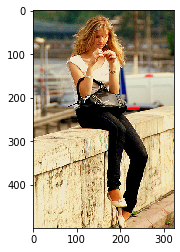

Greedy Search Caption: man in black shirt and jeans is walking down the street

Reference 1: a girl is sitting on by a lake
Reference 2: a girl with golden hair is sitting
Reference 3: a person is sitting

BLEU: 0.164


In [141]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
r1 = 'a girl is sitting on by a lake'
r2 = 'a girl with golden hair is sitting'
r3 = 'a person is sitting'
pic = list(encoding_test.keys())[85]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
caption = greedySearch(image)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',r1)
print('Reference 2:',r2)
print('Reference 3:',r3)
print()
print('BLEU:', round(sentence_bleu([r1, r2, r3], caption),3))
